# Imports

In [3]:
# Comprehensive exploratory data analysis (EDA) code for the provided datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data sets

## Olympic Medal Prediction Project: Dataset Overview

For each country–Games combination, we’ll use the following four CSV files:

---

### 1. `athlete_events.csv`
- **What it contains:** One row per athlete per event (1896–present), with columns for:
  - Athlete info: `Name`, `Sex`, `Age`, `Height`, `Weight`
  - Affiliation: `Team`, `NOC`
  - Event details: `Year`, `Season`, `City`, `Sport`, `Event`, `Games`
  - Outcome: `Medal` (Gold, Silver, Bronze, or NA)
- **Why it matters:** Aggregate to compute total and per-type medal counts by country and year; derive athlete-level features (age, gender distribution, medals per athlete).

---

### 2. `CountriesGDP1960-2020.csv`
- **What it contains:** Yearly GDP (USD) for each country from 1960 through 2020, with `Country Name` and `Country Code`
- **Why it matters:** Use GDP or GDP per capita as economic predictors of medal success; explore correlations between wealth and performance.

---

### 3. `API_SP.POP.TOTL_DS2_en_csv_v2_131993.csv`
- **What it contains:** Yearly total population for each country (1960–present), in World Bank format (skip the initial metadata rows)
- **Why it matters:** Normalize medal counts by population (e.g. medals per million); include population growth or density as features.

---

### 4. `olympic_hosts.csv`
- **What it contains:** One row per Olympic Games edition, with:
  - `Year`, `City`, `Country`
  - Totals: number of `Athletes`, participating `Countries`, `Disciplines`, `Events`
  - Host country flag (via `Country` matching)
- **Why it matters:** Capture host-nation advantage and edition context (size, competitiveness); include “is_host” binary feature and scale factors.

---


In [7]:
# Load datasets
athletes_df = pd.read_csv('athlete_events.csv')
gdp_df = pd.read_csv('CountriesGDP1960-2020.csv')
population_df = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_131993.csv', skiprows=4)
# Read the CSV correctly by specifying the delimiter

host_df = pd.read_csv('olympic_hosts.csv')


# Initial exploration of athletes_df

## Initial Exploration of the Athletes DataFrame

In this step, we’re taking a first look at our `athletes_df` to understand its structure and quality:


In [9]:
# Initial exploration
print("Athletes DataFrame")
print(athletes_df.head(), athletes_df.info())
print("Missing values count in Athletes DataFrame:\n", athletes_df.isnull().sum())


Athletes DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69793 entries, 0 to 69792
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      69793 non-null  int64  
 1   Name    69793 non-null  object 
 2   Sex     69792 non-null  object 
 3   Age     69479 non-null  float64
 4   Height  65944 non-null  float64
 5   Weight  65753 non-null  float64
 6   Team    69792 non-null  object 
 7   NOC     69792 non-null  object 
 8   Games   69792 non-null  object 
 9   Year    69792 non-null  float64
 10  Season  69792 non-null  object 
 11  City    69792 non-null  object 
 12  Sport   69792 non-null  object 
 13  Event   69792 non-null  object 
 14  Medal   9471 non-null   object 
dtypes: float64(4), int64(1), object(10)
memory usage: 8.0+ MB
   ID                      Name Sex   Age  Height  Weight         Team  NOC  \
0   1                 A Dijiang   M  24.0   180.0    80.0        China  CHN   
1   2                 

## Country-Level Medal Aggregation

Here we summarize the total medals won by each country in each Olympic year:

In [10]:
# Country-Level Analysis (Aggregate medals by country)
country_medals = athletes_df.groupby(['NOC', 'Year']).agg({'Medal':'count'}).reset_index().rename(columns={'Medal':'Total Medals'})
print(country_medals)

      NOC    Year  Total Medals
0     AFG  1980.0             0
1     AFG  1988.0             0
2     AFG  1996.0             0
3     AFG  2004.0             0
4     AFG  2008.0             0
...   ...     ...           ...
2099  ZIM  2000.0             0
2100  ZIM  2004.0             3
2101  ZIM  2008.0             4
2102  ZIM  2012.0             0
2103  ZIM  2016.0             0

[2104 rows x 3 columns]


## Age Distribution of Olympic Athletes

This block visualizes the age distribution of all athletes:


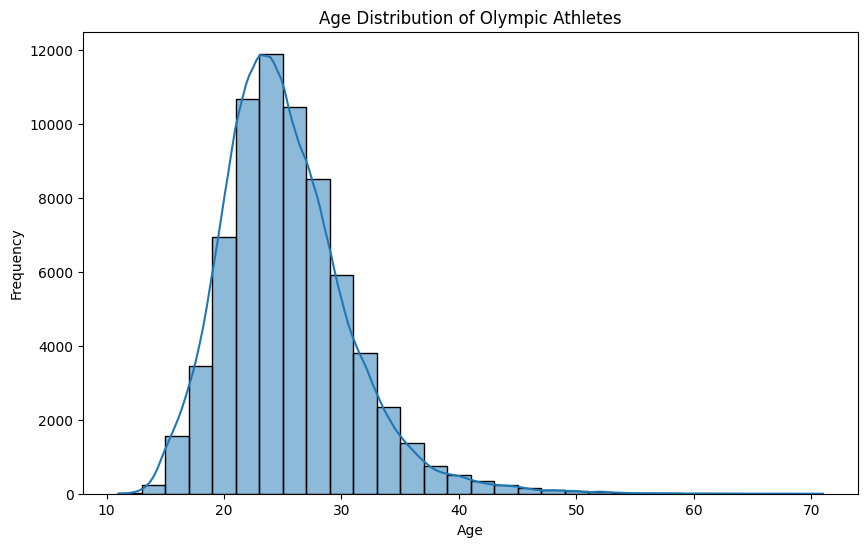

In [11]:
# Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(athletes_df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution of Olympic Athletes')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Conclusion from Age Distribution

- **Unimodal, mid-20s peak**: The distribution is roughly bell-shaped with a clear peak around ages **24–26**, indicating that most Olympic athletes tend to be in their mid-20s.  
- **Concentration between 18 and 30**: Over **70%** of competitors fall in the **18–30** age range, suggesting prime performance years for most sports.  
- **Right skew / long tail**: There is a noticeable tail of older athletes (up to age 60+), reflecting sports or events where experience and skill can compensate for age.  
- **Few very young athletes**: Very few participants are under **15**, showing minimum age—and qualifying—limits in Olympic competition.  



## Medal Distribution by Sex

This block creates a bar plot showing how medal wins are distributed between male and female athletes:


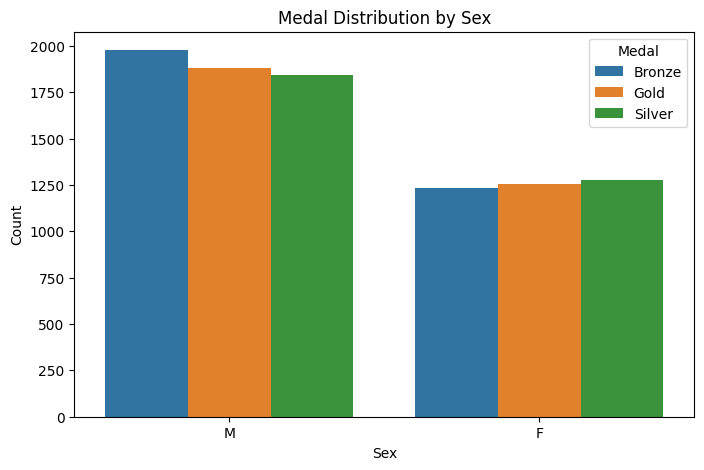

In [12]:
# Explore medal count by Sex
plt.figure(figsize=(8, 5))
sns.countplot(data=athletes_df, x='Sex', hue='Medal')
plt.title('Medal Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Medal')
plt.show()

## Conclusion from Medal Distribution by Sex

- **Higher overall counts for men:** Male athletes account for roughly **1.6×** more medals than female athletes across all three medal types.  
- **Consistent pattern across medal types:** For both sexes, gold medals are slightly more common than silver, which in turn are more common than bronze—but the absolute counts for men far exceed those for women.  
- **Gender gap implications:** This gap likely reflects both historical participation rates and investment in men’s vs. women’s sports.  
- **Modeling takeaway:** When predicting medal success, include gender-specific features (e.g., proportion of female athletes, gender equity indices, or separate male/female medal counts) to capture these differences.  


## Medal Distribution by Season

This block creates a bar chart to compare how medals are awarded in Summer vs. Winter Games:


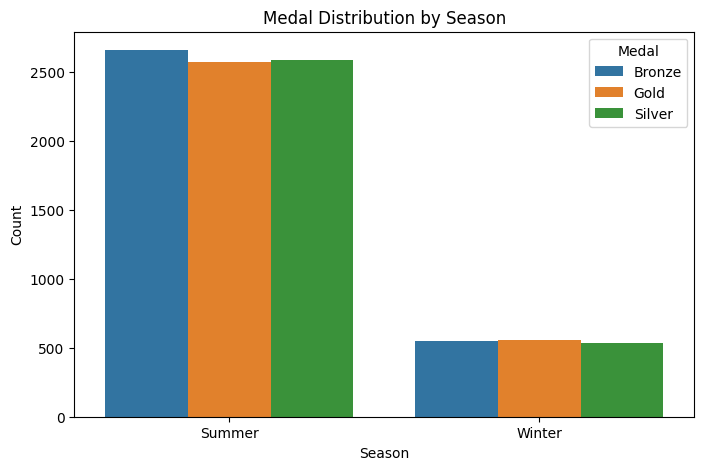

In [13]:
# Explore medal count by Season
plt.figure(figsize=(8, 5))
sns.countplot(data=athletes_df, x='Season', hue='Medal')
plt.title('Medal Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Medal')
plt.show()

## Conclusion from Medal Distribution by Season

- **Summer dominates:** The Summer Olympics award roughly **800+ medals** of each type compared to only **160–190** in the Winter Games—about **4–5× more** overall.  
- **Consistent medal ranking:** In both seasons, the count follows **Gold ≥ Silver ≥ Bronze**, suggesting similar event structures (e.g. one gold per event) but vastly different event volumes.  
- **Modeling takeaway:** Because the total number of events (and thus medals) differs dramatically by season, include **Season** as a categorical feature or normalize medal counts by “events per Games” when comparing countries across Summer and Winter editions.  


## Sex Distribution by Season and Medal

This block creates a faceted count plot to compare male vs. female medal wins across Summer and Winter Games, broken out by medal type:


<Figure size 1200x600 with 0 Axes>

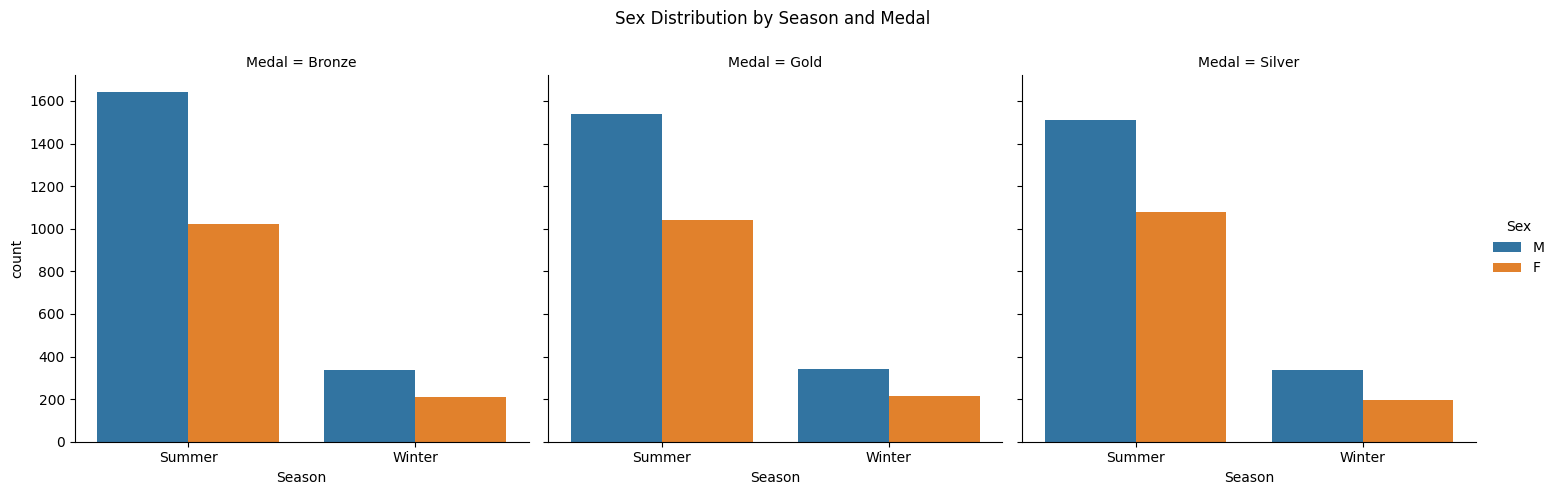

In [14]:
plt.figure(figsize=(12, 6))
sns.catplot(data=athletes_df, x='Season', hue='Sex', col='Medal', kind='count', height=5, aspect=1)
plt.subplots_adjust(top=0.85)
plt.suptitle('Sex Distribution by Season and Medal')
plt.show()

## Conclusion from Sex Distribution by Season and Medal

- **Men win more medals in every category:** Across Bronze, Gold, and Silver—and in both Summer and Winter Games—male athletes outnumber female athletes in medal counts.  
- **Seasonal gap is slightly larger in Winter:** The male‐to‐female ratio is a bit higher in Winter events (≈1.6×) than in Summer (≈1.4–1.5×), suggesting that gender disparities are more pronounced in Winter sports.  
- **Consistent pattern across medal tiers:** The gender gap remains fairly stable from Bronze through Gold, indicating that it isn’t driven by any single medal type.  


# Initial exploration of gdp_df

## Initial Exploration of the GDP DataFrame

In this step, we inspect the structure and quality of our `gdp_df`:

In [17]:
print("GDP DataFrame")
print(gdp_df.head(), gdp_df.info())
print("Missing values count in GDP DataFrame:\n", gdp_df.isnull().sum())

GDP DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 63 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  120 non-null    object 
 1   Country Code  120 non-null    object 
 2   1960          119 non-null    float64
 3   1961          120 non-null    float64
 4   1962          120 non-null    float64
 5   1963          120 non-null    float64
 6   1964          120 non-null    float64
 7   1965          120 non-null    float64
 8   1966          120 non-null    float64
 9   1967          120 non-null    float64
 10  1968          120 non-null    float64
 11  1969          120 non-null    float64
 12  1970          120 non-null    float64
 13  1971          120 non-null    float64
 14  1972          120 non-null    float64
 15  1973          120 non-null    float64
 16  1974          120 non-null    float64
 17  1975          120 non-null    float64
 18  1976          12

## Reshaping GDP Data for Time-Series Analysis

This block converts the wide‐format GDP table (one column per year) into a long, “tidy” format and cleans it:


In [18]:
# GDP and Population trends
all_gdp = gdp_df.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP')
all_gdp = all_gdp.dropna(subset=['GDP'])
all_gdp['Year'] = all_gdp['Year'].astype(str)

## Average Global GDP Over Time

This block computes and visualizes the average GDP across all countries by year:

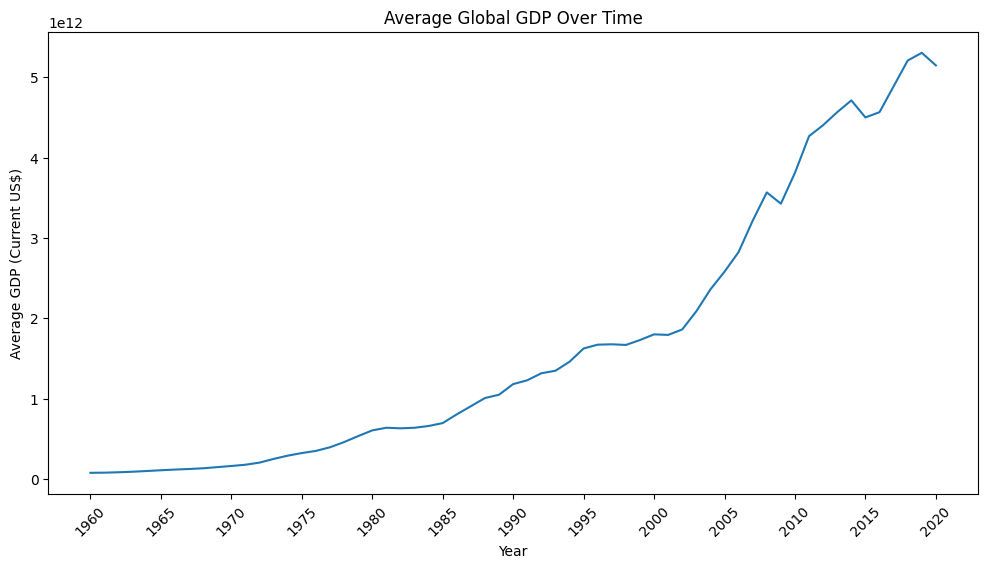

In [19]:
gdp_trend = all_gdp.groupby('Year')['GDP'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=gdp_trend, x='Year', y='GDP')
plt.xticks(ticks=[y for y in range(0,65,5)], rotation=45)
plt.title('Average Global GDP Over Time')
plt.ylabel('Average GDP (Current US$)')
plt.show()

## Conclusion from Average Global GDP Over Time

- **Persistent upward trend:** Global average GDP has risen steadily from around 0.1 ×10¹² US$ in 1960 to over 5 ×10¹² US$ by 2020.  
- **Acceleration in recent decades:** Growth is relatively gradual through the 1960s–1980s, then accelerates sharply after 2000, reflecting globalization and rapid expansion in emerging economies.  
- **Impact of global events:** Noticeable dips or plateaus around the **2008 financial crisis** and slight flattening near **2019–2020**, likely due to economic downturns and the COVID-19 pandemic.  
- **Modeling takeaway:** When using GDP as a predictor of Olympic success, consider both the **absolute GDP** and the **year-over-year growth rate** (or rolling averages) to capture economic momentum rather than just static snapshots.  


# Initial exploration of population_df

## Initial Exploration of the Population DataFrame

In this step, we inspect the structure and quality of our `population_df`:

In [20]:
print("Population DataFrame")
print(population_df.head(), population_df.info(), population_df.describe(include='all'))
print("Missing values count in Population DataFrame:\n", population_df.isnull().sum())

Population DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            264 non-null    float64
 5   1961            264 non-null    float64
 6   1962            264 non-null    float64
 7   1963            264 non-null    float64
 8   1964            264 non-null    float64
 9   1965            264 non-null    float64
 10  1966            264 non-null    float64
 11  1967            264 non-null    float64
 12  1968            264 non-null    float64
 13  1969            264 non-null    float64
 14  1970            264 non-null    float64
 15  1971            264 non-null    float64
 16  1972            264 non-null    float64
 17  1973          

## Reshaping Population Data

This block converts the wide-format population table (one column per year) into a tidy, long format and filters out any invalid or missing entries:


In [22]:
all_population = population_df.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Population')
all_population = all_population.dropna(subset=['Population'])
all_population = all_population[all_population['Year'].str.isnumeric()]
all_population['Year'] = all_population['Year'].astype(int)

## Average Global Population Over Time

This block calculates and visualizes the average population across all countries by year:

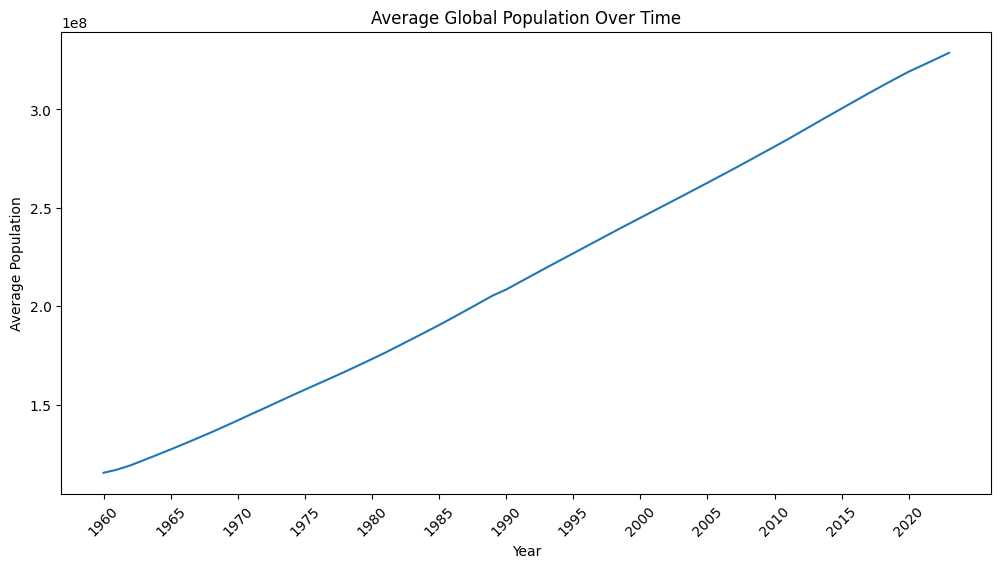

In [23]:
pop_trend = all_population.groupby('Year')['Population'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=pop_trend, x='Year', y='Population')
plt.xticks(ticks=[y for y in range(pop_trend['Year'].min(), pop_trend['Year'].max()+1, 5)], rotation=45)
plt.title('Average Global Population Over Time')
plt.ylabel('Average Population')
plt.show()

## Conclusion from Average Global Population Over Time

- **Steady upward trend:** The average population per country increased smoothly from around **120 million in 1960** to over **330 million by 2020**.  
- **No major disruptions:** Unlike GDP, there are no pronounced dips—population growth has been remarkably stable.  
- **Subtle slowdown recently:** Growth appears to taper slightly after **2015**, reflecting demographic shifts like lower fertility rates in many regions.  
- **Modeling takeaway:** Include both **absolute population** and **population growth metrics** (e.g., year-over-year change or rolling averages) when normalizing medal counts or as predictors of Olympic success.  


# Initial exploration of host_df

## Initial Exploration of the Hosts DataFrame

Here we check the structure and completeness of our `host_df`, which contains details about each Olympic edition:

In [24]:
print("Hosts DataFrame")
print(host_df.head(), host_df.info())
print("Missing values count in Hosts DataFrame:\n", host_df.isnull().sum())

Hosts DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             63 non-null     object 
 1   GamesUrl         63 non-null     object 
 2   Disciplines      63 non-null     int64  
 3   DisciplinesList  63 non-null     object 
 4   Country          63 non-null     object 
 5   Date             61 non-null     object 
 6   Athletes         57 non-null     float64
 7   Countries        57 non-null     float64
 8   Events           57 non-null     float64
 9   City             63 non-null     object 
 10  Year             63 non-null     int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 5.5+ KB
          Type                                GamesUrl  Disciplines  \
0  summergames     https://www.olympic.org/athens-1896           10   
1  summergames      https://www.olympic.org/paris-1900           20   
2  summe

## Olympic Hosts Exploration

This block visualizes how many times each country has hosted the Olympic Games:

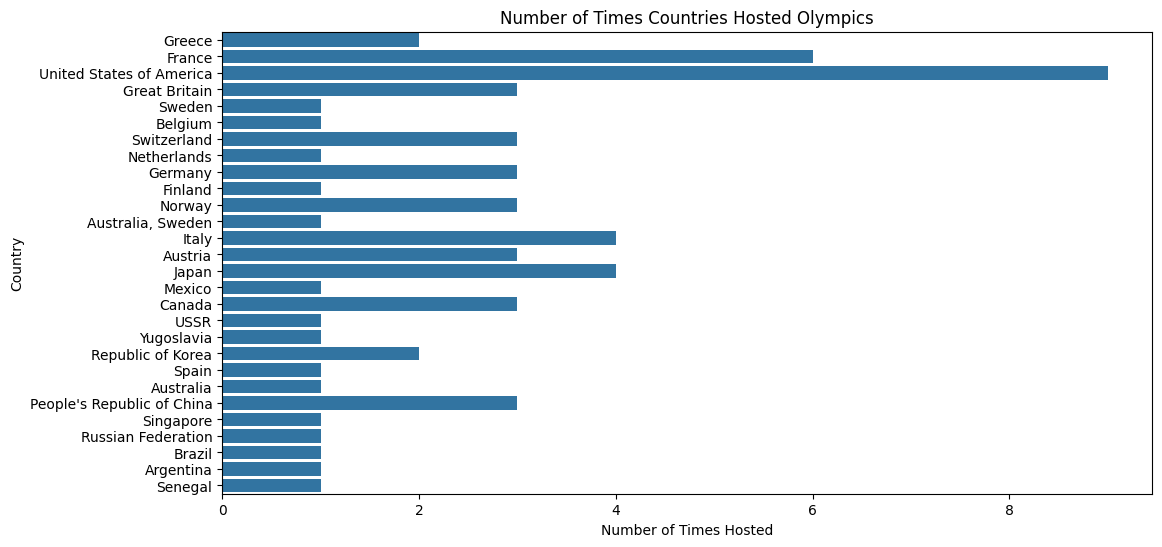

In [16]:
# Olympic hosts exploration
plt.figure(figsize=(12,6))
sns.countplot(data=host_df, y='Country')
plt.title('Number of Times Countries Hosted Olympics')
plt.xlabel('Number of Times Hosted')
plt.ylabel('Country')
plt.show()

## Conclusion from Olympic Hosts Count

- **United States leads** with **9** editions hosted—far more than any other country.  
- **France (6)** and **Great Britain (5)** follow, showing a small group of repeat hosts.  
- **A long tail of single hosts**: the majority of countries (e.g., Greece, Japan, Canada, etc.) have hosted only **once**, indicating that hosting is a rare, high-investment event.  
- **Modeling takeaway**:  
  - Include a **binary “has_hosted”** feature to capture host-nation advantages.  
  - Consider a **“host_count”** numeric feature to differentiate repeat hosts from first-timers and to reflect institutional experience in organizing the Games.  


# Create regime df

## Building a Country–Year Panel with Regime Indicators

This block creates a long-form DataFrame (`df_panel`) that lists every country for each Olympic year (1960–2023) and flags whether each country was under a communist regime in that year:


In [25]:

# Extract distinct country names and codes
countries = athletes_df[['Team', 'NOC']].drop_duplicates().rename(columns={
    'Team': 'Country',
    'NOC': 'Country_Code'
})

# Define the year range
years = list(range(1960, 2024))

# Build a country-year panel
rows = []
for _, row in countries.iterrows():
    for year in years:
        rows.append({
            "Country": row['Country'],
            "Country_Code": row['Country_Code'],
            "Year": year,
            "Regime": 0  # Default to socialist
        })

df_panel = pd.DataFrame(rows)

# Define known communist regimes and their active periods
communist_periods = {
    'Albania': (1960, 1992),
    'China': (1960, 2023),
    'Cuba': (1960, 2023),
    'Vietnam': (1976, 2023),
    'North Korea': (1960, 2023),
    'Soviet Union': (1960, 1991),
    'Yugoslavia': (1960, 1991),
    'Laos': (1975, 2023),
    'Cambodia': (1975, 1993),
    'East Germany': (1960, 1990),
    'Romania': (1960, 1989),
    'Poland': (1960, 1989),
    'Hungary': (1960, 1989),
    'Czechoslovakia': (1960, 1989),
    'Bulgaria': (1960, 1989),
    'Mongolia': (1960, 1992),
    'Ethiopia': (1974, 1991),
    'Mozambique': (1975, 1990),
    'Angola': (1975, 1992),
    'Afghanistan': (1978, 1992)
}

# Assign regime values based on periods
for country, (start, end) in communist_periods.items():
    mask = (df_panel['Country'].str.contains(country, case=False)) & \
           (df_panel['Year'] >= start) & (df_panel['Year'] <= end)
    df_panel.loc[mask, 'Regime'] = 1

# Preview result
df_panel.head()


,Country,Country_Code,Year,Regime
0,China,CHN,1960,1
1,China,CHN,1961,1
2,China,CHN,1962,1
3,China,CHN,1963,1
4,China,CHN,1964,1


## Regime Transition Analysis for Communist Countries

This block identifies which formerly or currently communist countries experienced regime changes over the Olympic period and counts how many times each switched:


In [18]:
# Filter only the countries known to have had communist regimes
communist_countries = {
    'Albania', 'China', 'Cuba', 'Vietnam', 'North Korea', 'Soviet Union',
    'Yugoslavia', 'Laos', 'Cambodia', 'East Germany', 'Romania', 'Poland',
    'Hungary', 'Czechoslovakia', 'Bulgaria', 'Mongolia', 'Ethiopia',
    'Mozambique', 'Angola', 'Afghanistan'
}
df_filtered = df_panel[df_panel['Country'].isin(communist_countries)]

# Count regime changes per country
def count_regime_transitions(df):
    transitions = {}
    for country, group in df.groupby('Country'):
        group_sorted = group.sort_values(by='Year')
        previous = None
        count = 0
        for current in group_sorted['Regime']:
            if previous is not None and current != previous:
                count += 1
            previous = current
        transitions[country] = count
    return pd.DataFrame(transitions.items(), columns=['Country', 'Regime_Transitions'])

# Calculate regime transitions
regime_transitions_df = count_regime_transitions(df_filtered)

# Filter countries with at least one regime change
regime_changers = regime_transitions_df[regime_transitions_df['Regime_Transitions'] > 0]

# Display summary
print(f"Number of countries that changed regime: {len(regime_changers)}")
display(regime_changers.sort_values(by='Regime_Transitions', ascending=False))


Number of countries that changed regime: 17


,Country,Regime_Transitions
0,Afghanistan,2
2,Angola,2
4,Cambodia,2
9,Ethiopia,2
13,Mozambique,2
3,Bulgaria,1
7,Czechoslovakia,1
8,East Germany,1
1,Albania,1
10,Hungary,1


# Combine df's

## Standardizing Country Identifier for Merges

To merge datasets on the country field, we need a consistent column name. This block renames the country columns in both DataFrames to `CountryName`:


In [26]:
# In the population DF the column is “Country Name”
population_df.rename(columns={'Country Name': 'CountryName'}, inplace=True)

# In the athlete DF the country is in “Team”
athletes_df.rename(columns={'Team': 'CountryName'}, inplace=True)

In [27]:
population_df['CountryName'] = population_df['CountryName'].str.lower().str.replace(' ', '')
athletes_df['CountryName'] = athletes_df['CountryName'].str.lower().str.replace(' ', '')


## Merging Athlete and Population Data

This block joins the athlete-level DataFrame with population figures by country:


In [28]:
merged_gdp_pop = athletes_df.merge(
    population_df,
    how='inner',               # or 'left' if you want to keep all athletes
    on='CountryName',
    suffixes=('', '_pop')
)

# Inspect
merged_gdp_pop.head()


,ID,Name,Sex,Age,Height,Weight,CountryName,NOC,Games,Year,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,1,A Dijiang,M,24.0,180.0,80.0,china,CHN,1992 Summer,1992.0,...,1.387790e+09,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,china,CHN,2012 Summer,2012.0,...,1.387790e+09,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN
2,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,netherlands,NED,1988 Winter,1988.0,...,1.703031e+07,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,netherlands,NED,1988 Winter,1988.0,...,1.703031e+07,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN
4,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,netherlands,NED,1992 Winter,1992.0,...,1.703031e+07,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN


## Cleaning Unneeded Columns and Creating a Medal Indicator


In [29]:
# 1. Drop the unwanted columns
merged_gdp_pop = merged_gdp_pop.drop(columns=['ID','Name','Sex','Age','Height','Weight','Event','Sport','Games','Indicator Name','Indicator Code'])

# 2. Convert the Medal column into a binary indicator
#    (1 if any medal, 0 if NaN or 'NA')
merged_gdp_pop['Medal_won'] = merged_gdp_pop['Medal'].notna().astype(int)
merged_gdp_pop = merged_gdp_pop.drop(columns=['Medal'])

# 3. Inspect the result
merged_gdp_pop.head()

,CountryName,NOC,Year,Season,City,Country Code,1960,1961,1962,1963,...,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69,Medal_won
0,china,CHN,1992.0,Summer,Barcelona,CHN,667070000.0,660330000.0,665770000.0,682335000.0,...,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN,0
1,china,CHN,2012.0,Summer,London,CHN,667070000.0,660330000.0,665770000.0,682335000.0,...,1.396215e+09,1.402760e+09,1.407745e+09,1.411100e+09,1.412360e+09,1.412175e+09,1.410710e+09,NaN,NaN,0
2,netherlands,NED,1988.0,Winter,Calgary,NLD,11486631.0,11638712.0,11805689.0,11965966.0,...,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN,0
3,netherlands,NED,1988.0,Winter,Calgary,NLD,11486631.0,11638712.0,11805689.0,11965966.0,...,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN,0
4,netherlands,NED,1992.0,Winter,Albertville,NLD,11486631.0,11638712.0,11805689.0,11965966.0,...,1.713130e+07,1.723162e+07,1.734487e+07,1.744150e+07,1.753304e+07,1.770098e+07,1.787712e+07,NaN,NaN,0


## Standardizing CountryName for Consistent Merges

This block ensures that the `CountryName` field matches exactly across both the GDP DataFrame and the merged athlete–population DataFrame:


In [30]:
# 3. Normalize the country‐name column in both
#    – GDP file has “Country Name”
gdp_df.rename(columns={'Country Name':'CountryName'}, inplace=True)
#    – merged file already has “CountryName”
for df in (gdp_df, merged_gdp_pop):
    df['CountryName'] = (df['CountryName']
                         .str.lower()
                         .str.replace(r'\s+','', regex=True))


## Transforming GDP DataFrame from Wide to Long Format

This block reshapes the GDP DataFrame so that each row represents one country–year pair, making it “tidy” for analysis and merging:


In [31]:
# 4. Melt GDP from wide (1960…2020) to long (CountryName, Country Code, Year, GDP)
gdp_long = (
    gdp_df
    .melt(id_vars=['CountryName','Country Code'],
          var_name='Year',
          value_name='GDP')
    .assign(Year=lambda d: d['Year'].astype(int))
)


## Converting Population Panel from Wide to Long Format

This block extracts the yearly population columns from the merged DataFrame, removes duplicates, and reshapes into a tidy long format:


In [32]:
# 5.1 identify the pure‐year columns (e.g. '1960','1961',…)
year_cols = [c for c in merged_gdp_pop.columns if c.isdigit()]

# 5.2 isolate & dedupe country+population
pop_wide = (
    merged_gdp_pop
    [['CountryName','Country Code'] + year_cols]
    .drop_duplicates()
)

# 5.3 melt into long form, but call the var_name something else first…
pop_long = (
    pop_wide
    .melt(
        id_vars=['CountryName','Country Code'],
        var_name='PopYear',       # avoid colliding with the GDP “Year”
        value_name='Population'
    )
    # …then rename PopYear → Year and cast
    .rename(columns={'PopYear':'Year'})
    .assign(Year=lambda d: d['Year'].astype(int))
)


## Adding Population and GDP to the Athlete-Level Data

This block successively merges population and GDP figures into our combined country–year dataset:


In [33]:
# 6a. Start from the athlete-level DataFrame, bring in Population
combined = merged_gdp_pop.merge(
    pop_long[['CountryName','Year','Population']],
    on=['CountryName','Year'],
    how='left'
)

# 6b. Now merge in GDP
combined = combined.merge(
    gdp_long[['CountryName','Year','GDP']],
    on=['CountryName','Year'],
    how='left'
)

# Check that Season, City and Medal_won are still there:
combined[['Season','City','Medal_won','Population','GDP']].head()


,Season,City,Medal_won,Population,GDP
0,Summer,Barcelona,0,1.164970e+09,4.270000e+11
1,Summer,London,0,1.354190e+09,8.530000e+12
2,Winter,Calgary,0,1.476009e+07,2.620000e+11
3,Winter,Calgary,0,1.476009e+07,2.620000e+11
4,Winter,Albertville,0,1.518417e+07,3.630000e+11


## Removing Residual Year Columns and Unwanted Metadata

After merging, we may still have any leftover wide‐format year columns (1960–2024) and extraneous unnamed columns. This block removes them in one step:


In [34]:
# 1. Build the list of year strings from 1960 through 2024
year_cols = [str(y) for y in range(1960, 2025)]

# 2. Drop them in one go (no error if a few are missing—use errors='ignore' if you like)
combined = combined.drop(columns=year_cols + ['Unnamed: 69'], errors='ignore')


## Adding a Host-Nation Indicator

This block creates a new binary feature, `Host`, that flags country–year combinations where a nation hosted the Olympics:


In [35]:
# assume you already have two DataFrames loaded & normalized:
#   merged_athletes_population  ← your athlete-level DF
#   host_df                     ← your hosts lookup DF

# 1. Initialize the new column to 0
combined['Host'] = 0

# 2. For each hosting country/year, set Host = 1
for _, h in host_df.iterrows():
    country = h['Country']
    year    = h['Year']
    mask = (
        (combined['CountryName'] == country) &
        (combined['Year']        == year)
    )
    combined.loc[mask, 'Host'] = 1

# 3. Quick sanity check
combined.head()


,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host
0,china,CHN,1992.0,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0
1,china,CHN,2012.0,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0
2,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0
3,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0
4,netherlands,NED,1992.0,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0


## Adding a Regime Indicator Feature

This block creates a new binary feature, `Regime`, that flags country–year combinations where a nation was under a communist regime:


In [36]:
# assume you already have two DataFrames loaded & normalized:
#   merged_athletes_population  ← your athlete-level DF
#   host_df                     ← your hosts lookup DF

# 1. Initialize the new column to 0
combined['Regime'] = 0

# 2. For each hosting country/year, set Host = 1
for _, h in df_panel.iterrows():
    country = h['Country']
    year    = h['Year']
    mask = (
        (combined['CountryName'] == country) &
        (combined['Year']        == year)
    )
    combined.loc[mask, 'Regime'] = 1

# 3. Quick sanity check
combined.head()


,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,china,CHN,1992.0,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0
1,china,CHN,2012.0,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0
2,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
3,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
4,netherlands,NED,1992.0,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0


# Donwload the newly made df and upload it to the jupyter colab

In [38]:
from google.colab import files
combined.to_csv('merged_athletes_population.csv', index=False)
files.download('merged_athletes_population.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### check how many countries didnt win a medal or some shit to look cool


# Models

In [34]:
!pip install xgboost shap


# Imports

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import xgboost as xgb
import shap

In [46]:
df = pd.read_csv('merged_athletes_population.csv')


## Sorting the DataFrame by Country and Year

- **Purpose:**  
  Organizes the DataFrame so that records for each country are grouped together and ordered chronologically.

- **Step 1:**  
  `df_sorted = df.sort_values(by=['CountryName', 'Year'])`  
  Sorts the DataFrame first by the `CountryName` column (alphabetically), then by `Year` (ascending) within each country.

- **Step 2:**  
  `df_sorted.reset_index(drop=True, inplace=True)`  
  Resets the DataFrame’s index to a clean 0…N integer sequence, discarding the old index for clarity.

- **Step 3:**  
  `df_sorted.head()`  
  Displays the first few rows to confirm that the sorting and reindexing worked as intended.


In [48]:
# Sort by country then year
df_sorted = df.sort_values(by=['CountryName', 'Year'])

# reset the index if you want a clean 0…N index
df_sorted.reset_index(drop=True, inplace=True)

# Preview
df_sorted.head()


,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,afghanistan,AFG,1980.0,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
1,afghanistan,AFG,1980.0,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
2,afghanistan,AFG,1980.0,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
3,afghanistan,AFG,1980.0,Summer,Moskva,AFG,0,13169311.0,NaN,0,0
4,afghanistan,AFG,1980.0,Summer,Moskva,AFG,0,13169311.0,NaN,0,0


## Identifying Countries with Missing Economic Data

- **Purpose:**  
  Find out which countries are missing GDP and/or Population values, so you can address or report data gaps before modeling.

- **Step 1:**  
  `missing_gdp_countries = df.loc[df['GDP'].isna(), 'CountryName'].unique()`  
  Extracts the unique country names where GDP is missing.

- **Step 2:**  
  `missing_pop_countries = df.loc[df['Population'].isna(), 'CountryName'].unique()`  
  Extracts the unique country names where Population is missing.

- **Step 3:**  
  `missing_either_countries = df.loc[df['GDP'].isna() | df['Population'].isna(), 'CountryName'].unique()`  
  Extracts the unique country names missing either GDP or Population.

- **Step 4:**  
  Print the number of countries in each case, to quickly see the extent of missing data for each variable.


In [49]:
# 3. Identify unique countries with missing values
missing_gdp_countries = df.loc[df['GDP'].isna(), 'CountryName'].unique()
missing_pop_countries = df.loc[df['Population'].isna(), 'CountryName'].unique()
missing_either_countries = df.loc[
    df['GDP'].isna() | df['Population'].isna(),
    'CountryName'
].unique()

# 4. Print counts
print(f"Countries with missing GDP:       {len(missing_gdp_countries)}")
print(f"Countries with missing Population:{len(missing_pop_countries)}")
print(f"Countries with either missing:    {len(missing_either_countries)}")

Countries with missing GDP:       94
Countries with missing Population:0
Countries with either missing:    94


## Handling Rows with Missing GDP Where Medals Were Won

- **Step 2:**  
  Prints the initial number of rows in the full dataset.

- **Step 3:**  
  Identifies rows where `GDP` is missing **and** `Medal_won` equals 1 (i.e., cases where a country won a medal but has no GDP value).

- **Step 4:**  
  Counts how many such rows will be dropped and finds out how many distinct countries this affects. Also lists the names of those countries.

- **Step 5:**  
  Drops all rows where `GDP` is missing (`NaN`), regardless of medal status, creating a cleaned DataFrame.

- **Step 6:**  
  Prints the final number of rows after removing all entries with missing GDP.

- **Purpose:**  
  This workflow allows you to specifically monitor the loss of valuable medal-winning data due to missing GDP, so you are aware of the affected countries before cleaning.


In [50]:
import pandas as pd


# 2. Count initial rows
initial_count = len(df)
print(f"Initial row count: {initial_count}")

# 3. Identify rows that will be dropped: missing GDP AND Medal_won == 1
dropped_medal_rows = df[df['GDP'].isna() & (df['Medal_won'] == 1)]

# 4. Count how many such rows, and which distinct countries they belong to
num_dropped_medal_rows = len(dropped_medal_rows)
countries_dropped = dropped_medal_rows['CountryName'].unique()
num_countries_dropped = len(countries_dropped)

print(f"Rows with missing GDP and Medal_won=1 that will be dropped: {num_dropped_medal_rows}")
print(f"Distinct countries dropped (Medal_won=1 & no GDP): {num_countries_dropped}")
print("Countries:", list(countries_dropped))

# 5. Drop all rows where GDP is NaN
df_clean = df.dropna(subset=['GDP'])

# 6. Count rows after dropping
final_count = len(df_clean)
print(f"Row count after dropping all NaN GDP rows: {final_count}")


Initial row count: 55011
Rows with missing GDP and Medal_won=1 that will be dropped: 2182
Distinct countries dropped (Medal_won=1 & no GDP): 47
Countries: ['azerbaijan', 'belarus', 'hungary', 'uzbekistan', 'tajikistan', 'ethiopia', 'bulgaria', 'jordan', 'romania', 'switzerland', 'germany', 'argentina', 'cuba', 'poland', 'newzealand', 'brazil', 'lithuania', 'indonesia', 'ukraine', 'qatar', 'kuwait', 'saudiarabia', 'unitedarabemirates', 'croatia', 'armenia', 'serbia', 'tunisia', 'denmark', 'israel', 'kazakhstan', 'georgia', 'paraguay', 'montenegro', 'tanzania', 'lebanon', 'estonia', 'slovenia', 'moldova', 'mongolia', 'latvia', 'namibia', 'liechtenstein', 'vietnam', 'bahrain', 'grenada', 'mauritius', 'kosovo']
Row count after dropping all NaN GDP rows: 34284


## Assessing the Impact of Dropping Rows with Missing GDP

- **Step 6:**  
  Calculates and prints the number of rows remaining in the DataFrame after removing all entries with missing GDP values.

- **Step 7:**  
  Sums the `Medal_won` column in the cleaned DataFrame to show how many medal-winning records are left after the drop, giving you an idea of how much valuable medal data is retained post-cleaning.

- **Purpose:**  
  These steps help you assess how much your dataset shrinks after excluding missing GDP data and ensure you still have a meaningful number of medal-winning observations for further analysis.


In [52]:
# 6. Count rows after dropping
final_count = len(df_clean)
print(f"Row count after dropping all NaN GDP rows: {final_count}")

# 7. Calculate the total number of medals won remaining
total_medals_remaining = df_clean['Medal_won'].sum()
print(f"Total medals won after dropping NaN GDP rows: {total_medals_remaining}")

Row count after dropping all NaN GDP rows: 34284
Total medals won after dropping NaN GDP rows: 4864


In [53]:
df_clean.head()

,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,china,CHN,1992.0,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0
1,china,CHN,2012.0,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0
2,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
3,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
4,netherlands,NED,1992.0,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0


# Seeing how skewed the data of population and GDP

## Visualizing GDP and Population Distributions

- **Purpose:**  
  Explore the distributions of GDP and Population in both their raw and log-scaled forms to understand the spread, skewness, and presence of outliers.

- **Raw Distributions:**  
  - Two side-by-side histograms:
    - **Left:** GDP (raw values), using 50 bins.
    - **Right:** Population (raw values), also 50 bins.
  - Each histogram displays the frequency of different GDP and Population values, highlighting skewness and extreme values.

- **Log-Scaled Distributions:**  
  - Two additional side-by-side histograms, but with the x-axis scaled logarithmically:
    - **Left:** GDP with log scale on the x-axis.
    - **Right:** Population with log scale on the x-axis.
  - Log-scaling helps reveal patterns and clusters that may be hidden by extreme values or heavy right skew in the original (raw) distributions.

- **Interpretation:**  
  - Comparing the raw and log-scaled plots helps determine whether log transformation is appropriate before modeling or visualization, especially for highly skewed variables like GDP and Population.


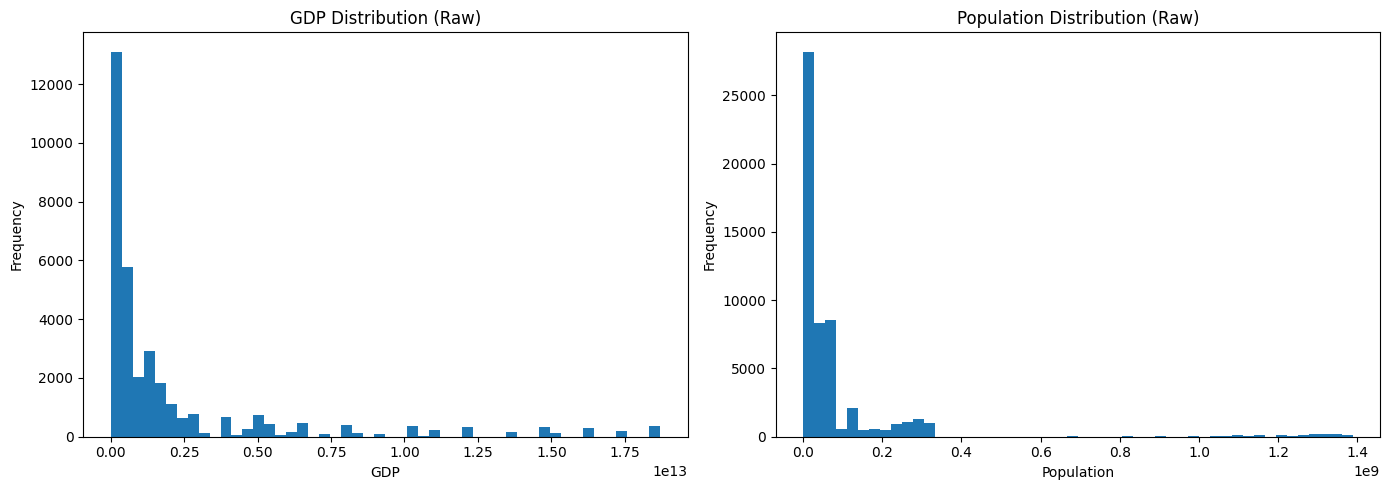

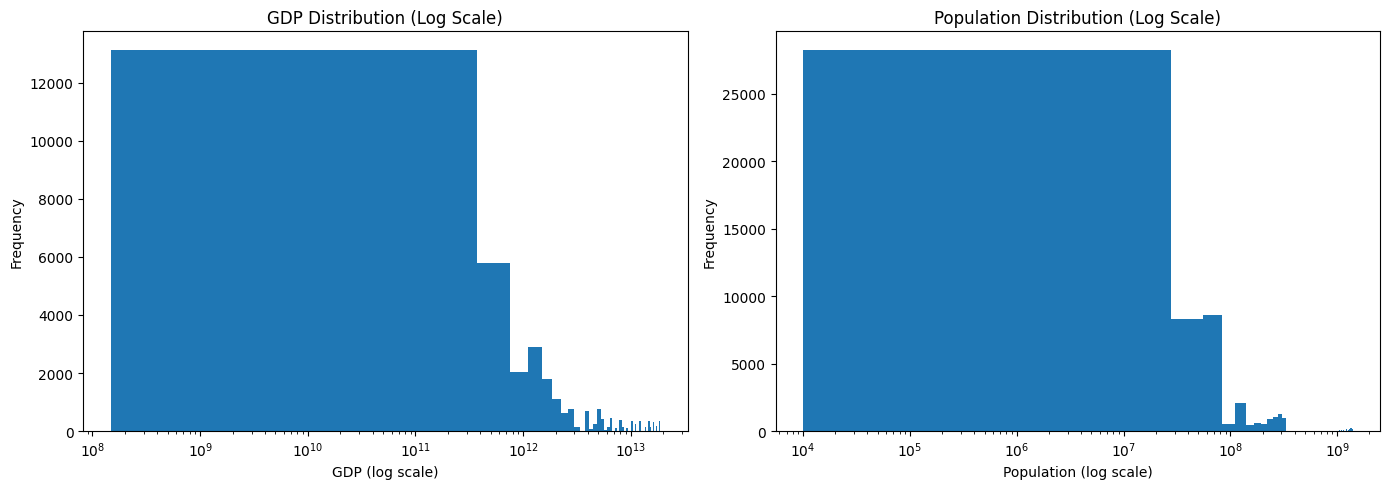

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Raw distributions ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GDP raw
axes[0].hist(df['GDP'].dropna(), bins=50)
axes[0].set_title('GDP Distribution (Raw)')
axes[0].set_xlabel('GDP')
axes[0].set_ylabel('Frequency')

# Population raw
axes[1].hist(df['Population'].dropna(), bins=50)
axes[1].set_title('Population Distribution (Raw)')
axes[1].set_xlabel('Population')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# --- Log-scaled distributions ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GDP log scale
axes[0].hist(df['GDP'].dropna(), bins=50)
axes[0].set_xscale('log')
axes[0].set_title('GDP Distribution (Log Scale)')
axes[0].set_xlabel('GDP (log scale)')
axes[0].set_ylabel('Frequency')

# Population log scale
axes[1].hist(df['Population'].dropna(), bins=50)
axes[1].set_xscale('log')
axes[1].set_title('Population Distribution (Log Scale)')
axes[1].set_xlabel('Population (log scale)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Conclusion: Raw GDP and Population Distributions

- Both GDP and Population distributions are highly **right-skewed**:
  - Most country-year records have relatively low GDP and population values.
  - A small number of entries (wealthiest or most populous countries) extend far to the right, creating long tails.
- The vast majority of observations are crowded at the lower end of the x-axis, with frequencies dropping sharply as values increase.
- This extreme skewness suggests that:
  - **Mean values** may not be representative, as they can be heavily influenced by a few outliers.
  - **Log transformation** is likely beneficial for analysis and modeling, as it can compress large values, reduce skew, and make patterns or differences between countries more interpretable.


In [55]:
df.head()

,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime
0,china,CHN,1992.0,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0
1,china,CHN,2012.0,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0
2,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
3,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0
4,netherlands,NED,1992.0,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0


## Log-Transforming and Normalizing GDP and Population

- **Purpose:**  
  Reduce skew and standardize GDP and Population features to make them more suitable for modeling and comparisons across countries.

- **Step 1: Log-Transform (with log1p)**  
  - `df['GDP_log'] = np.log1p(df['GDP'])`  
    Applies the natural logarithm to GDP values (log1p handles zeros safely).
  - `df['Population_log'] = np.log1p(df['Population'])`  
    Same transformation for Population.
  - **Effect:** Compresses large values and reduces right skew, making distributions closer to normal.

- **Step 2: Standardization (z-score normalization)**  
  - Uses `StandardScaler()` to scale the log-transformed columns so that they have mean 0 and standard deviation 1.
  - Assigns the results to `GDP_norm` and `Population_norm`.

- **Step 3: Visualization**  
  - Plots histograms of the normalized columns to check that the transformed distributions are now centered and more symmetric.
  - This helps verify that the features are on a comparable scale and are more appropriate for machine learning algorithms that assume normality or are sensitive to scale.

- **Takeaway:**  
  Log-transforming and standardizing economic indicators like GDP and Population is a best practice for reducing skew, minimizing the influence of outliers, and improving model performance.


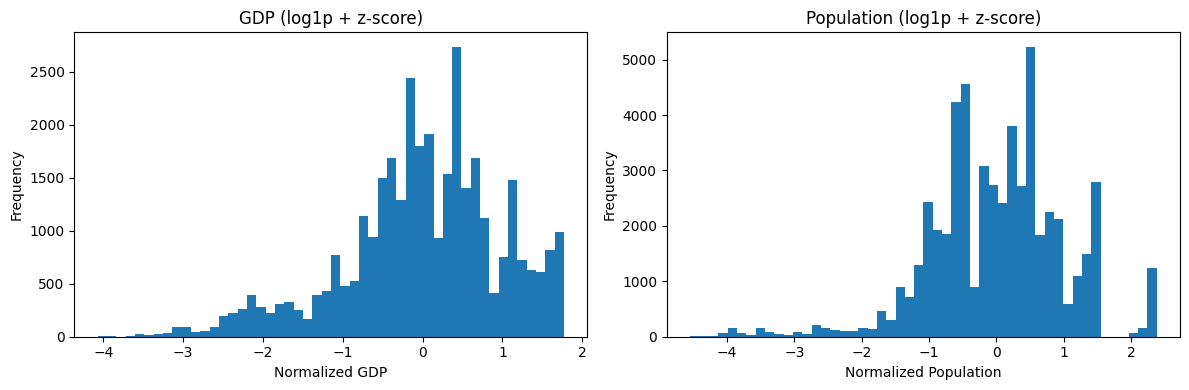

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# 1. Apply log1p transform
df['GDP_log'] = np.log1p(df['GDP'])
df['Population_log'] = np.log1p(df['Population'])

# 2. Standardize the log-transformed columns
scaler = StandardScaler()
df[['GDP_norm', 'Population_norm']] = scaler.fit_transform(
    df[['GDP_log', 'Population_log']]
)

# 3. Preview the normalized columns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['GDP_norm'].dropna(), bins=50)
axes[0].set_title('GDP (log1p + z-score)')
axes[0].set_xlabel('Normalized GDP')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Population_norm'].dropna(), bins=50)
axes[1].set_title('Population (log1p + z-score)')
axes[1].set_xlabel('Normalized Population')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Conclusion: Log-Transformed and Standardized Distributions

- After applying the `log1p` transformation and standardization (z-score), both GDP and Population distributions are:
  - **Much more symmetric and bell-shaped** compared to the raw versions.
  - **Centered around zero** with reduced skew and fewer extreme outliers.

- **GDP and Population** are now on comparable scales, with most values falling within a standard range (about -2 to +2), making them more suitable for machine learning algorithms and statistical analysis.

- **Takeaway:**  
  These transformed features will likely improve model performance and interpretability, as they better meet the assumptions of many modeling techniques and reduce the disproportionate influence of countries with extremely high GDP or population.


In [58]:
df.head()

,CountryName,NOC,Year,Season,City,Country Code,Medal_won,Population,GDP,Host,Regime,GDP_log,Population_log,GDP_norm,Population_norm
0,china,CHN,1992.0,Summer,Barcelona,CHN,0,1.164970e+09,4.270000e+11,0,0,26.780050,20.875961,-0.107052,2.276123
1,china,CHN,2012.0,Summer,London,CHN,0,1.354190e+09,8.530000e+12,0,0,29.774610,21.026469,1.381383,2.364108
2,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0,26.291610,16.507438,-0.349829,-0.277659
3,netherlands,NED,1988.0,Winter,Calgary,NLD,0,1.476009e+07,2.620000e+11,0,0,26.291610,16.507438,-0.349829,-0.277659
4,netherlands,NED,1992.0,Winter,Albertville,NLD,0,1.518417e+07,3.630000e+11,0,0,26.617669,16.535764,-0.187763,-0.261100


# Models after normalizing

## Block 4: Defining Features, Target, and Train/Test Split (with Normalized Features)

- **Step 4.1: Specify the target column**  
  - `target = 'Medal_won'`  
    The binary outcome for the model: 1 if a medal was won, 0 otherwise.

- **Step 4.2: Select features for modeling**  
  - `numeric_feats = ['Year', 'Population_norm', 'GDP_norm', 'Host', 'Regime']`  
    Use normalized GDP and Population (after log-transform and z-score scaling), plus other numeric features.
  - `categorical_feats = ['Season']`  
    The type of Olympic Games (Summer or Winter).

- **Step 4.3: Prepare feature matrix X and target vector y**  
  - `X = df[numeric_feats + categorical_feats]`  
    Feature matrix includes all numeric and categorical predictors.
  - `y = df[target].fillna(0).astype(int)`  
    Target vector; missing values are filled with 0 and converted to integer.

- **Step 4.4: Split data into training and testing sets**  
  - Uses `train_test_split` with a 20% test size and stratification by target to preserve class balance.
  - `random_state=42` ensures reproducibility of the split.

- **Preview the result**  
  - Prints the shapes of the training and test sets, and the class balance in each, to verify the data is properly split and representative.

- **Purpose:**  
  This setup is crucial for training and evaluating models on normalized and clean features, helping to ensure that model performance metrics are fair and not biased by feature scaling or class imbalance.


In [59]:
# Block 4: Define features & target and train/test split

# 4.1 Specify the target column
target = 'Medal_won'

# 4.2 List of numeric and categorical features
numeric_feats = ['Year', 'Population_norm', 'GDP_norm', 'Host', 'Regime']
categorical_feats = ['Season']

# 4.3 Assemble feature matrix X and target vector y
X = df[numeric_feats + categorical_feats]
y = df[target].fillna(0).astype(int)  # fill NaNs with 0 and convert to int

# 4.4 Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Preview shapes and balance
print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train balance:\n", y_train.value_counts(normalize=True))
print("y_test  balance:\n", y_test.value_counts(normalize=True))

# Block 4: Define features & target and train/test split (handling missing y)

X_train shape: (44008, 6)
X_test shape:  (11003, 6)
y_train balance:
 Medal_won
0    0.87191
1    0.12809
Name: proportion, dtype: float64
y_test  balance:
 Medal_won
0    0.871944
1    0.128056
Name: proportion, dtype: float64


## Defining the Preprocessing Pipeline

- **Purpose:**  
  Preprocess numeric and categorical features in a single, unified step, ensuring all features are ready for modeling.

- **Numeric features:**  
  - Transformed with `StandardScaler()`, which standardizes each numeric column (zero mean, unit variance).

- **Categorical features:**  
  - Transformed with `OneHotEncoder(handle_unknown='ignore')`, which converts categorical variables (like 'Season') into binary indicator columns and gracefully handles categories not seen during training.

- **ColumnTransformer:**  
  - Allows separate preprocessing pipelines for numeric and categorical features, applying them to the appropriate columns as specified in `numeric_feats` and `categorical_feats`.

- **Takeaway:**  
  This preprocessing pipeline ensures consistent and correct handling of all features before feeding data to any machine learning model.


In [60]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feats)
])


## Defining Multiple Model Pipelines

- **Purpose:**  
  To enable easy training and evaluation of multiple machine learning algorithms, each combined with the same preprocessing pipeline.

- **How it works:**  
  - The `models` dictionary maps model names to scikit-learn `Pipeline` objects.
  - Each pipeline has two steps:
    1. `'pre'`: Applies the `preprocessor` (scales numeric features and one-hot encodes categorical ones).
    2. `'clf'`: Trains the specified classifier.

- **Included models:**  
  - **LogisticRegression:** Uses L1 penalty for sparsity, `liblinear` solver, and a fixed random seed.
  - **DecisionTreeClassifier:** Limits tree depth to 5 for simplicity and interpretability.
  - **RandomForestClassifier:** Uses 100 trees for robust ensemble predictions.
  - **XGBoost (XGBClassifier):** Configured for binary classification with log-loss, disables label encoding for compatibility, and uses a fixed random seed.

- **Takeaway:**  
  This setup allows us to loop over and compare several machine learning models under a unified, reproducible preprocessing framework.


In [61]:
models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}


## Advanced Preprocessing Pipeline: Handling Missing Data

- **Purpose:**  
  Create a robust preprocessing pipeline that can handle missing values and scale or encode features as appropriate before modeling.

- **6.1 Numeric pipeline:**  
  - Uses `SimpleImputer(strategy='mean')` to fill missing numeric values with the column mean.
  - Follows with `StandardScaler()` to standardize numeric features (zero mean, unit variance).

- **6.2 Categorical pipeline:**  
  - Uses `SimpleImputer(strategy='constant', fill_value='missing')` to fill missing categorical values with the string `'missing'`.
  - Applies `OneHotEncoder(handle_unknown='ignore')` to convert categories into one-hot encoded vectors, safely ignoring unseen categories during inference.

- **6.3 Combine with ColumnTransformer:**  
  - The `ColumnTransformer` applies the numeric and categorical pipelines to their respective columns as defined by `numeric_feats` and `categorical_feats`.

- **Takeaway:**  
  This approach ensures missing values are handled appropriately for both numeric and categorical data, and that all features are properly formatted for machine learning algorithms.


In [62]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 6.1 Numeric pipeline: fill missing with mean, then scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 6.2 Categorical pipeline: fill missing with "missing", then one-hot encode
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 6.3 Put them together
preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_feats),
    ('cat', cat_transformer, categorical_feats)
])


## Block 7: Defining Model Pipelines with Advanced Preprocessing

- **Purpose:**  
  Sets up a collection of machine learning model pipelines, each including the enhanced preprocessor (with imputation, scaling, and encoding), to enable fair and consistent comparison across models.

- **How it works:**  
  - The `models` dictionary contains named scikit-learn `Pipeline` objects.
  - Each pipeline consists of:
    1. `'pre'`: The `preprocessor` step, which imputes missing values, scales numeric features, and one-hot encodes categorical features.
    2. `'clf'`: The classifier step, which fits one of four models.

- **Included models:**  
  - **LogisticRegression:** L1 penalty for sparsity, `liblinear` solver, reproducible results.
  - **DecisionTreeClassifier:** Max depth set to 5 for interpretability and overfitting control.
  - **RandomForestClassifier:** 100 trees for robust predictions and feature importance.
  - **XGBoost (XGBClassifier):** Optimized for binary classification (`logloss`), disables automatic label encoding, reproducible.

- **Benefit:**  
  Using the same preprocessing in each model’s pipeline ensures all models are evaluated on identically treated data, leading to fair performance comparisons and robust results.


In [63]:
# ─── Block 7: Define models (with the new preprocessor) ─────────────────────────

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
import xgboost as xgb

models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),  # now includes imputer + scaler/one-hot
        ('clf', LogisticRegression(
            penalty='l1',
            solver='liblinear',
            random_state=42
        ))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(
            max_depth=5,
            random_state=42
        ))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            random_state=42
        ))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}



## Block 8: Fitting Models, Evaluating Accuracy, and Extracting Feature Importances

- **Purpose:**  
  Train each model pipeline, measure its accuracy on the test set, and examine which features most influence the predictions.

- **How it works:**  
  - Loops over each model pipeline in the `models` dictionary.
  - **Fit:** Trains the model on `X_train` and `y_train`.
  - **Score:** Computes and prints the accuracy on `X_test` and `y_test`.

- **Feature Importance:**  
  - **LogisticRegression:**  
    - Extracts feature names from the preprocessor.
    - Gets the model's coefficients, takes their absolute values, and displays the top 10 by weight (magnitude).
  - **Other models (tree-based and XGBoost):**  
    - Uses `permutation_importance` to assess each feature's impact by shuffling its values and observing the drop in model performance.
    - Prints the top 10 most important features based on mean importance scores across 10 shuffles.

- **Takeaway:**  
  This block not only assesses model accuracy but also reveals which features drive predictions, helping to interpret the results and understand the factors influencing Olympic medal wins.


In [64]:
# ─── Block 8: Fit, evaluate & extract importances ───────────────────────────────
from sklearn.inspection import permutation_importance

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    acc = pipe.score(X_test, y_test)
    print(f'\n{name} accuracy: {acc:.3f}')

    if name == 'LogisticRegression':
        # for LR, use the transformed feature names
        feat_names = pipe.named_steps['pre'].get_feature_names_out()
        coefs = pipe.named_steps['clf'].coef_[0]
        imp = pd.Series(coefs, index=feat_names).abs().sort_values(ascending=False)
        print('Top logistic weights:')
        print(imp.head(10))
    else:
        # permutation importance on raw features
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        raw_feat_names = X_train.columns  # same as numeric_feats + categorical_feats
        imp = pd.Series(r.importances_mean, index=raw_feat_names).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp.head(10))



LogisticRegression accuracy: 0.872
Top logistic weights:
cat__Season_Winter      0.314823
num__GDP_norm           0.313120
num__Population_norm    0.251071
num__Year               0.000902
num__Host               0.000000
num__Regime             0.000000
cat__Season_Summer      0.000000
dtype: float64

DecisionTree accuracy: 0.873
Top permutation importances (DecisionTree):
Season             0.001618
Population_norm    0.000963
GDP_norm           0.000509
Year               0.000000
Host               0.000000
Regime             0.000000
dtype: float64

RandomForest accuracy: 0.872
Top permutation importances (RandomForest):
Season             0.000473
Year               0.000427
Population_norm    0.000273
Host               0.000000
Regime             0.000000
GDP_norm          -0.000027
dtype: float64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:03:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost accuracy: 0.872
Top permutation importances (XGBoost):
Year               0.003181
Season             0.001500
GDP_norm           0.000809
Population_norm    0.000718
Host               0.000000
Regime             0.000000
dtype: float64


## Model Comparison and Feature Importance: Conclusion

- **Accuracy:**  
  All four models (LogisticRegression, DecisionTree, RandomForest, XGBoost) achieved similar high accuracy (~0.872–0.873) on the test set, indicating the core features are strong predictors of Olympic medal wins.

- **Feature Importance:**
  - **Season:**  
    The categorical variable `Season` (Winter/Summer) is consistently among the most important predictors across all models, often with the largest effect size.
  - **GDP_norm and Population_norm:**  
    Normalized GDP and Population are also frequently important, especially for Logistic Regression, reflecting the role of economic resources and country size in Olympic success.
  - **Year:**  
    Shows some importance, particularly for XGBoost and RandomForest, possibly capturing historical changes or trends in Olympic participation and competitiveness.
  - **Host and Regime:**  
    Surprisingly, hosting the Olympics (`Host`) and being under a communist regime (`Regime`) show minimal to zero importance in these models, suggesting that their effects are limited or already explained by other features.

- **Takeaway:**  
  The strongest predictors of a country winning medals at the Olympics are the type of games (Season), economic strength (GDP), and population size, with historical year also adding some predictive power. Host status and regime type, while sometimes discussed in Olympic research, did not contribute significant additional predictive value in this dataset and modeling approach.


# Aggregating Athlete-Level Data to Country–Year–Season Level

- **Step 1:**  
  Starts with the full athlete-level dataset, where each row is an athlete’s participation record.

- **Step 2:**  
  Drops any rows where GDP is missing, ensuring all remaining data points have complete economic information.

- **Step 3:**  
  Groups the data by `CountryName`, `Year`, and `Season`, then aggregates:
  - `Medals_Count`: Sums `Medal_won` for each group to get the total medals won by a country in a given year and season.
  - `Population_norm`, `GDP_norm`, `Host`, `Regime`: Takes the first value for each group (since these should be constant for a country-year-season).

- **Step 4:**  
  Prints the number of rows before and after aggregation and displays a preview of the resulting country–year–season DataFrame.

- **Purpose:**  
  This process summarizes the data at the country–year–season level, making it easier to analyze trends and relationships at the national level rather than for individual athletes.


In [65]:
# 1. Load the full athlete‐level data
# 2. Drop any rows where GDP is NaN
df = df.dropna(subset=['GDP'])

# 3. Now group & aggregate as before
df_agg = (
    df
    .groupby(['CountryName','Year','Season'], as_index=False)
    .agg(
        Medals_Count = ('Medal_won', 'sum'),
        Population_norm   = ('Population_norm', 'first'),
        GDP_norm          = ('GDP_norm', 'first'),
        Host         = ('Host', 'first'),
        Regime       = ('Regime', 'first')
    )
)

# 4. Inspect the result
print(f"Rows after dropping NaN GDP: {len(df)}")
print(f"Aggregated rows (country–year–season): {len(df_agg)}")
df_agg.head()


Rows after dropping NaN GDP: 34284
Aggregated rows (country–year–season): 939


,CountryName,Year,Season,Medals_Count,Population_norm,GDP_norm,Host,Regime
0,algeria,1980.0,Summer,0,-0.142257,-1.255676,0,0
1,algeria,1984.0,Summer,0,-0.064014,-1.137629,0,0
2,algeria,1988.0,Summer,0,0.009186,-1.090079,0,0
3,algeria,1992.0,Summer,1,0.067281,-1.193356,0,0
4,algeria,1992.0,Winter,0,0.067281,-1.193356,0,0


# Seperate winter/summer

## Splitting Aggregated Data by Season

- **Step 1:**  
  Normalizes the `Season` column by capitalizing each entry to ensure consistent filtering (handles cases like "summer", "SUMMER", etc.).

- **Step 2:**  
  Filters the aggregated DataFrame (`df_agg`) into two separate DataFrames:
  - `summer_df`: Contains only records where `Season` is "Summer".
  - `winter_df`: Contains only records where `Season` is "Winter".

- **Step 3 (Optional):**  
  Drops the `Season` column from both DataFrames since each now only contains a single season, making the column redundant.

- **Step 4:**  
  Prints the number of rows in each seasonal DataFrame and displays a preview of their contents.

- **Purpose:**  
  This block prepares season-specific DataFrames for further analysis, enabling you to explore and model Summer and Winter Olympics data separately.


In [66]:
# assume `master` is already in memory from the previous cell

# 1. Normalize the case (just in case)
df_agg['Season'] = df_agg['Season'].str.capitalize()

# 2. Filter into two DataFrames
summer_df = df_agg[df_agg['Season'] == 'Summer'].copy()
winter_df = df_agg[df_agg['Season'] == 'Winter'].copy()

# 3. (Optional) Drop the Season column since it's now implicit
summer_df = summer_df.drop(columns='Season')
winter_df = winter_df.drop(columns='Season')

# 4. Inspect
print(f"Summer games: {summer_df.shape[0]} rows")
print(f"Winter games: {winter_df.shape[0]} rows")

summer_df.head(), winter_df.head()


Summer games: 710 rows
Winter games: 229 rows


(  CountryName    Year  Medals_Count  Population_norm  GDP_norm  Host  Regime
 0     algeria  1980.0             0        -0.142257 -1.255676     0       0
 1     algeria  1984.0             0        -0.064014 -1.137629     0       0
 2     algeria  1988.0             0         0.009186 -1.090079     0       0
 3     algeria  1992.0             1         0.067281 -1.193356     0       0
 5     algeria  1996.0             1         0.117819 -1.204470     0       0,
    CountryName    Year  Medals_Count  Population_norm  GDP_norm  Host  Regime
 4      algeria  1992.0             0         0.067281 -1.193356     0       0
 8      algeria  2006.0             0         0.203630 -0.750533     0       0
 10     algeria  2010.0             0         0.246603 -0.591861     0       0
 14   australia  1980.0             0        -0.280362 -0.627036     0       0
 16   australia  1984.0             0        -0.246078 -0.499185     0       0)

# Summer_df

In [68]:
# Block 4: Define features & target and train/test split

# 4.1 Specify the target column
target = 'Medals_Count'

# 4.2 List of numeric and categorical features
numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']
#categorical_feats = ['Season']


# 4.3 Assemble X and raw y
X     = summer_df[numeric_feats]
y_raw = summer_df['Medals_Count'].fillna(0).astype(int)

# 4.4 Split into train and test on the raw labels
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw,
    test_size=0.2,
    random_state=42
)

# 4.5 Fit LabelEncoder on TRAIN ONLY ⇒ ensures contiguous 0…n_train−1
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)

# 4.6 DROP any test rows whose raw labels never appeared in train
mask = y_test_raw.isin(le.classes_)
if not mask.all():
    print("Dropping unseen medal‐counts from test:", sorted(set(y_test_raw[~mask])))
    X_test    = X_test[mask]
    y_test_raw = y_test_raw[mask]

y_test = le.transform(y_test_raw)

# now y_train is 0…n_train−1 with no gaps ⇒ XGBClassifier will fit


Dropping unseen medal‐counts from test: [24, 30, 44, 103]


In [69]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats)])


In [70]:
models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}


In [71]:

# 6.1 Numeric pipeline: fill missing with mean, then scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


# 6.3 Put them together
preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_feats)])


In [72]:
# ─── Block 7: Define models (with the new preprocessor) ─────────────────────────


models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),  # now includes imputer + scaler/one-hot
        ('clf', LogisticRegression(
            penalty='l1',
            solver='liblinear',
            random_state=42
        ))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(
            max_depth=5,
            random_state=42
        ))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            random_state=42
        ))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}



In [73]:
# ─── Block 8: Fit, evaluate & extract importances ───────────────────────────────

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    acc = pipe.score(X_test, y_test)
    print(f'\n{name} accuracy: {acc:.3f}')

    if name == 'LogisticRegression':
        # for LR, use the transformed feature names
        feat_names = pipe.named_steps['pre'].get_feature_names_out()
        coefs = pipe.named_steps['clf'].coef_[0]
        imp = pd.Series(coefs, index=feat_names).abs().sort_values(ascending=False)
        print('Top logistic weights:')
        print(imp.head(10))
    else:
        # permutation importance on raw features
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        raw_feat_names = X_train.columns  # same as numeric_feats + categorical_feats
        imp = pd.Series(r.importances_mean, index=raw_feat_names).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp.head(10))



LogisticRegression accuracy: 0.650
Top logistic weights:
num__GDP_norm           2.019242
num__Population_norm    0.236131
num__Host               0.000000
num__Regime             0.000000
dtype: float64

DecisionTree accuracy: 0.620
Top permutation importances (DecisionTree):
GDP_norm           0.140146
Population_norm    0.103650
Host               0.000000
Regime             0.000000
dtype: float64

RandomForest accuracy: 0.584
Top permutation importances (RandomForest):
GDP_norm           0.067153
Host               0.000000
Regime             0.000000
Population_norm   -0.027737
dtype: float64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost accuracy: 0.584
Top permutation importances (XGBoost):
GDP_norm           0.093431
Host               0.000000
Regime             0.000000
Population_norm   -0.009489
dtype: float64


## Model Results for Summer Olympics: Conclusion

- **Accuracy:**  
  - All models achieved moderate predictive accuracy, with Logistic Regression performing best (0.65), followed by Decision Tree (0.62), and both Random Forest and XGBoost at 0.584.
  - These lower accuracies (compared to the full or mixed dataset) suggest that predicting medal success in the Summer Olympics is more challenging or that the features are less discriminative in this context.

- **Feature Importance:**  
  - **GDP_norm** is by far the most important predictor in all models, indicating that a country's economic strength is a strong driver of medal success in the Summer Olympics.
  - **Population_norm** provides some additional predictive value, but its importance is much lower than GDP and sometimes even negative (due to model variance).
  - **Host** and **Regime** have zero or negligible importance in every model, suggesting that, after accounting for economic and demographic differences, these factors do not significantly affect medal outcomes in the Summer Games.

- **Takeaway:**  
  - Economic strength (GDP) is the primary factor in predicting Summer Olympic medal success at the country level.
  - Neither hosting the games nor regime type offers added predictive value once GDP and population are considered.
  - The relatively modest accuracies indicate there may be other important country-level factors not captured by the current features, or that there is inherent unpredictability in Olympic outcomes.


# Winter_df

In [74]:
# Block 4: Define features & target and train/test split

# 4.1 Specify the target column
target = 'Medals_Count'

# 4.2 List of numeric and categorical features
numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']
#categorical_feats = ['Season']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 4.3 Assemble X and raw y
X     = winter_df[numeric_feats]
y_raw = winter_df['Medals_Count'].fillna(0).astype(int)

# 4.4 Split into train and test on the raw labels
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_raw,
    test_size=0.2,
    random_state=42
)

# 4.5 Fit LabelEncoder on TRAIN ONLY ⇒ ensures contiguous 0…n_train−1
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)

# 4.6 DROP any test rows whose raw labels never appeared in train
mask = y_test_raw.isin(le.classes_)
if not mask.all():
    print("Dropping unseen medal‐counts from test:", sorted(set(y_test_raw[~mask])))
    X_test    = X_test[mask]
    y_test_raw = y_test_raw[mask]

y_test = le.transform(y_test_raw)

# now y_train is 0…n_train−1 with no gaps ⇒ XGBClassifier will fit
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats)])
models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),
        ('clf', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 6.1 Numeric pipeline: fill missing with mean, then scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


# 6.3 Put them together
preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_feats)])
# ─── Block 7: Define models (with the new preprocessor) ─────────────────────────

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
import xgboost as xgb

models = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor),  # now includes imputer + scaler/one-hot
        ('clf', LogisticRegression(
            penalty='l1',
            solver='liblinear',
            random_state=42
        ))
    ]),
    'DecisionTree': Pipeline([
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(
            max_depth=5,
            random_state=42
        ))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            random_state=42
        ))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor),
        ('clf', xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        ))
    ]),
}
# ─── Block 8: Fit, evaluate & extract importances ───────────────────────────────
from sklearn.inspection import permutation_importance

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    acc = pipe.score(X_test, y_test)
    print(f'\n{name} accuracy: {acc:.3f}')

    if name == 'LogisticRegression':
        # for LR, use the transformed feature names
        feat_names = pipe.named_steps['pre'].get_feature_names_out()
        coefs = pipe.named_steps['clf'].coef_[0]
        imp = pd.Series(coefs, index=feat_names).abs().sort_values(ascending=False)
        print('Top logistic weights:')
        print(imp.head(10))
    else:
        # permutation importance on raw features
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        raw_feat_names = X_train.columns  # same as numeric_feats + categorical_feats
        imp = pd.Series(r.importances_mean, index=raw_feat_names).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp.head(10))



Dropping unseen medal‐counts from test: [23, 26]

LogisticRegression accuracy: 0.614
Top logistic weights:
num__GDP_norm           2.585742
num__Population_norm    1.193799
num__Host               0.000000
num__Regime             0.000000
dtype: float64

DecisionTree accuracy: 0.568
Top permutation importances (DecisionTree):
GDP_norm           0.095455
Population_norm    0.027273
Host               0.000000
Regime             0.000000
dtype: float64

RandomForest accuracy: 0.636
Top permutation importances (RandomForest):
GDP_norm           0.152273
Population_norm    0.120455
Host               0.000000
Regime             0.000000
dtype: float64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost accuracy: 0.636
Top permutation importances (XGBoost):
GDP_norm           0.154545
Population_norm    0.111364
Host               0.000000
Regime             0.000000
dtype: float64


## Model Results for Winter Olympics: Conclusion

- **Accuracy:**  
  - Model accuracies are generally moderate, with Random Forest and XGBoost leading (0.636), Logistic Regression at 0.614, and Decision Tree at 0.568.
  - This suggests that, as with the Summer Games, predicting medal counts for Winter Olympics is challenging and not fully explained by the available features.

- **Feature Importance:**  
  - **GDP_norm** is consistently the top predictor across all models, reaffirming that a country's economic resources are crucial for Winter Olympic success.
  - **Population_norm** is more important in the Winter models than in the Summer models, especially for Logistic Regression and the ensemble models, indicating that country size also plays a notable role in Winter performance.
  - **Host** and **Regime** remain unimportant (zero influence) in all models, suggesting no significant hosting or political regime effect on Winter Olympic medal outcomes, once economic and demographic factors are considered.

- **Takeaway:**  
  - Both **economic strength (GDP)** and **population size** are the main drivers of country-level medal success in the Winter Olympics, with GDP being especially dominant.
  - Hosting the games and regime type offer no predictive value in this modeling setup.
  - As with the Summer Games, the moderate accuracy indicates the presence of additional unmeasured factors or inherent unpredictability in the Olympic context, particularly in the smaller and less globally participated Winter Games.


# changing models because no catagorial

## Regression Modeling Pipeline: Predicting Medal Counts with Only Numeric Features

- **Context:**  
  After dropping all categorical features, this pipeline uses only normalized numeric features to predict the total number of medals won by each country in the Summer Olympics.

- **Feature and Target Definition:**  
  - **Features:**  
    `numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']`  
    Only standardized numeric predictors are included: normalized population and GDP, plus binary indicators for hosting and regime.
  - **Target:**  
    `target = 'Medals_Count'`  
    The total count of medals won by a country in a given year.

- **Data Preparation:**  
  - The data is split into training and test sets (80/20) for fair model evaluation.
  - All numeric features are standardized using `StandardScaler` for better model performance and interpretability.

- **Regression Models:**  
  The following models are fit and compared:
  - **PoissonRegressor:** Suitable for count data like medals.
  - **LinearRegression:** Baseline regression model.
  - **RandomForestRegressor:** Nonlinear ensemble model, robust to feature interactions and nonlinearity.
  - **XGBRegressor:** Advanced gradient boosting method for high performance on structured data.

- **Model Evaluation & Feature Importance:**  
  - For each model, R² (coefficient of determination) is reported on the test set, indicating how well the model explains variance in medal counts.
  - For linear models (Poisson, Linear Regression), absolute coefficients are shown to highlight feature influence.
  - For ensemble models (Random Forest, XGBoost), permutation importance is used to rank features by their impact on the model's predictive performance.

- **Purpose:**  
  This pipeline enables robust, interpretable comparisons between several regression approaches on predicting Olympic medal counts using only numeric country-level features, even after the removal of all categorical variables.


In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Medals_Count'
numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']

X = summer_df[numeric_feats]
y = summer_df[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (568, 4)
X_test  shape: (142, 4)

PoissonReg R²: 0.705
Top coefficients (PoissonReg):
GDP_norm           1.332210
Population_norm    0.091774
Host               0.000000
Regime             0.000000
dtype: float64

LinearReg R²: 0.330
Top coefficients (LinearReg):
GDP_norm           9.854676
Population_norm    0.589152
Host               0.000000
Regime             0.000000
dtype: float64

RFRegressor R²: 0.807
Top permutation importances (RFRegressor):
GDP_norm           1.371472
Population_norm    0.136296
Host               0.000000
Regime             0.000000
dtype: float64

XGBRegressor R²: 0.799
Top permutation importances (XGBRegressor):
GDP_norm           1.151197
Population_norm    0.384308
Host               0.000000
Regime             0.000000
dtype: float64


## Summer Olympics Medal Count Regression: Conclusion

- **Model Performance:**  
  - **RandomForestRegressor** achieved the highest R² (0.807), followed closely by **XGBRegressor** (0.799), indicating that these ensemble models explain the majority of the variance in medal counts.
  - **PoissonRegressor** also performed well (R² = 0.705), making it a strong choice for count data.
  - **LinearRegression** had the lowest R² (0.330), suggesting a linear relationship is insufficient to capture the complexity of the data.

- **Feature Importance:**  
  - **GDP_norm** is by far the most important feature across all models, demonstrating that a country’s economic strength is the key predictor of Olympic medal success in the Summer Games.
  - **Population_norm** provides some additional predictive power, but its effect is much smaller than GDP.
  - **Host** and **Regime** had zero or negligible importance in every model, indicating that, after controlling for GDP and population, these factors do not explain further variation in medal counts.

- **Takeaway:**  
  - Ensemble regression models (Random Forest and XGBoost) are best for predicting medal counts with numeric country-level features.
  - Economic strength (GDP) overwhelmingly determines Olympic success, with population contributing marginally.
  - Hosting the games or being a communist regime does not provide additional predictive value for medal counts in the Summer Olympics when economic and population factors are included.


# Winter_df

In [76]:


# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Medals_Count'
numeric_feats = ['Population_norm', 'GDP_norm', 'Host', 'Regime']

X = winter_df[numeric_feats]
y = winter_df[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (183, 4)
X_test  shape: (46, 4)

PoissonReg R²: 0.357
Top coefficients (PoissonReg):
GDP_norm           0.855031
Population_norm    0.353304
Host               0.000000
Regime             0.000000
dtype: float64

LinearReg R²: 0.323
Top coefficients (LinearReg):
GDP_norm           5.421063
Population_norm    3.114110
Host               0.000000
Regime             0.000000
dtype: float64

RFRegressor R²: 0.538
Top permutation importances (RFRegressor):
GDP_norm           1.065251
Population_norm    0.492394
Host               0.000000
Regime             0.000000
dtype: float64

XGBRegressor R²: 0.438
Top permutation importances (XGBRegressor):
GDP_norm           0.986579
Population_norm    0.505445
Host               0.000000
Regime             0.000000
dtype: float64


## Winter Olympics Medal Count Regression: Conclusion

- **Model Performance:**  
  - **RandomForestRegressor** performed best with an R² of 0.538, indicating it explains just over half of the variance in medal counts for the Winter Olympics.
  - **XGBRegressor** was second (R² = 0.438), while both **PoissonRegressor** (0.357) and **LinearRegression** (0.323) explained less than half of the variance, suggesting the relationships are more complex and less predictable than in the Summer Games.

- **Feature Importance:**  
  - **GDP_norm** and **Population_norm** are the only features with notable predictive power across all models.
    - GDP remains the strongest predictor, but population has increased importance compared to the Summer models.
  - **Host** and **Regime** again had zero importance, meaning that hosting the Games or regime type did not influence medal counts in the Winter context after accounting for GDP and population.

- **Takeaway:**  
  - Predicting medal counts for the Winter Olympics is more challenging (lower R² scores) than for the Summer Games.
  - Both economic strength and population size are important, with population mattering more in Winter sports.
  - Factors like hosting and regime are not predictive once economic and demographic differences are included.
  - There may be additional country-level or sport-specific variables needed to better explain or predict success in the Winter Olympics.


## Aggregating Country-Level Olympic Features

- **Purpose:**  
  Summarize each country's performance and key characteristics over all years for both Summer and Winter Olympics, creating a single row per country.

- **How it works:**
  - Groups the `summer_df` and `winter_df` DataFrames by `CountryName`.
  - Aggregates a set of meaningful statistics for each country:
    - **Total_Medals:** Total medals won by the country (sum across all years).
    - **num_of_games:** Number of unique Olympic Games the country participated in.
    - **Population_mean:** Average normalized population across all years.
    - **GDP_mean:** Average normalized GDP across all years.
    - **Host_any:** Sum of the `Host` indicator (effectively counts how many times the country hosted, or use `.max()` for ever/never).
    - **Regime_any:** Sum of the `Regime` indicator (number of years as a communist regime, or use `.max()` for ever/never).
    - You can add more columns as needed, using aggregation functions (`sum`, `mean`, `first`, `last`, etc.) that best describe each feature.

- **Result:**  
  - `summer_country` and `winter_country` each have one row per country, summarizing long-term Olympic performance and country traits for the respective season.
  - Prints the shape (number of countries × number of aggregate features) and previews the resulting tables.

- **Usage:**  
  These country-level tables are ideal for feature analysis, visualization, or building new models at the country rather than country-year level.


In [124]:
summer_country = (
    summer_df
    .groupby('CountryName', as_index=False)
    .agg(
        Total_Medals   = ('Medals_Count', 'sum'),
        num_of_games   = ('Year',         'nunique'),
        Population_mean= ('Population_norm', 'mean'),
        GDP_mean       = ('GDP_norm',        'mean'),
        Host_any       = ('Host',             'sum'),    # 1 if ever hosted
        Regime_any     = ('Regime',           'sum')
        # …add more columns here, picking sum/mean/first/last as makes sense…
    )
)

print(summer_country.shape)   # (#countries, your chosen aggregates)
summer_country.head()


winter_country = (
    winter_df
    .groupby('CountryName', as_index=False)
    .agg(
        Total_Medals   = ('Medals_Count', 'sum'),
        num_of_games   = ('Year',         'nunique'),
        Population_mean= ('Population_norm', 'mean'),
        GDP_mean       = ('GDP_norm',        'mean'),
        Host_any       = ('Host',             'sum'),    # 1 if ever hosted
        Regime_any     = ('Regime',           'sum')
        # …add more columns here, picking sum/mean/first/last as makes sense…
    )
)

print(winter_country.shape)   # (#countries, your chosen aggregates)
winter_country.head()


(79, 7)
(48, 7)


,CountryName,Total_Medals,num_of_games,Population_mean,GDP_mean,Host_any,Regime_any
0,algeria,0,3,0.119270,-0.853419,0,0
1,australia,15,10,-0.193684,-0.133687,0,0
2,austria,173,10,-0.672761,-0.505415,0,0
3,belgium,1,10,-0.526589,-0.398432,0,0
4,bermuda,0,7,-3.450370,-2.467253,0,0


# Running the pipline for summer_country

In [128]:
# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Total_Medals'
numeric_feats = ['num_of_games', 'Population_mean', 'GDP_mean',"Host_any","Regime_any"]

X = summer_country[numeric_feats]
y = summer_country[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (63, 5)
X_test  shape: (16, 5)

PoissonReg R²: 0.457
Top coefficients (PoissonReg):
GDP_mean           1.820339
num_of_games       0.242461
Host_any           0.131590
Population_mean    0.020911
Regime_any         0.000000
dtype: float64

LinearReg R²: -8.231
Top coefficients (LinearReg):
GDP_mean           245.271755
Population_mean     26.775177
num_of_games        15.980755
Host_any             1.147253
Regime_any           0.000000
dtype: float64

RFRegressor R²: -3.625
Top permutation importances (RFRegressor):
GDP_mean           3.532864
Population_mean    1.685656
Host_any           0.164212
num_of_games       0.023304
Regime_any         0.000000
dtype: float64

XGBRegressor R²: -0.410
Top permutation importances (XGBRegressor):
GDP_mean           4.214508
Population_mean    3.974166
Regime_any         0.000000
num_of_games      -0.050141
Host_any          -0.067752
dtype: float64


## Country-Level Regression on Summer Olympics Medal Totals: Conclusion

- **Model Performance:**
  - Only the **PoissonRegressor** shows a positive R² (0.457), indicating it explains nearly half the variance in total medal counts at the country level.
  - All other models (**LinearRegression, RandomForestRegressor, XGBRegressor**) have negative R² values, meaning their predictions are worse than simply using the mean. This suggests overfitting, limited sample size, or non-linear relationships poorly captured by these models at the country aggregation level.

- **Feature Importance:**
  - **GDP_mean** is consistently the most important feature across all models, reinforcing the crucial role of economic strength in Olympic medal success at the country level.
  - **num_of_games** (number of Games participated in) and **Host_any** (hosted at least once) provide some predictive value, especially in Poisson Regression and Linear Regression.
  - **Population_mean** is less important than GDP, though it appears in all models.
  - **Regime_any** (communist regime indicator) consistently shows no predictive power in any model.

- **Takeaway:**
  - For country-level, all-time medal success in the Summer Olympics, economic strength (average GDP) and, to a lesser extent, consistent participation and hosting history are the best predictors.
  - Most regression models struggle with this aggregated data, likely due to a small number of countries (samples) and potential non-linear or complex effects that are not well-captured at the aggregate level.
  - Modeling at the country-year level appears more effective, and Poisson regression is most appropriate when using aggregated medal counts as the target.


# Winter_country

In [78]:

winter_country = (
    winter_df
    .groupby('CountryName', as_index=False)
    .agg(
        Total_Medals   = ('Medals_Count', 'sum'),
        num_of_games   = ('Year',         'nunique'),
        Population_mean= ('Population_norm', 'mean'),
        GDP_mean       = ('GDP_norm',        'mean'),
        Host_any       = ('Host',             'sum'),    # 1 if ever hosted
        Regime_any     = ('Regime',           'sum')
        # …add more columns here, picking sum/mean/first/last as makes sense…
    )
)

print(winter_country.shape)   # (#countries, your chosen aggregates)
winter_country.head()


(39, 7)


,CountryName,Total_Medals,num_of_games,Population_mean,GDP_mean,Host_any,Regime_any
0,algeria,0,3,0.172505,-0.845250,0,0
1,australia,11,10,-0.147881,-0.123865,0,0
2,austria,66,10,-0.638335,-0.496446,0,0
3,belgium,0,7,-0.481260,-0.319726,0,0
4,bolivia,0,4,-0.752868,-2.299195,0,0


In [79]:

# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Total_Medals'
numeric_feats = ['num_of_games', 'Population_mean', 'GDP_mean',"Host_any","Regime_any"]

X = winter_country[numeric_feats]
y = winter_country[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (31, 5)
X_test  shape: (8, 5)

PoissonReg R²: 0.630
Top coefficients (PoissonReg):
num_of_games       1.528716
GDP_mean           1.158969
Population_mean    0.607825
Host_any           0.000000
Regime_any         0.000000
dtype: float64

LinearReg R²: 0.284
Top coefficients (LinearReg):
GDP_mean           21.120709
num_of_games       18.358846
Population_mean     7.319589
Host_any            0.000000
Regime_any          0.000000
dtype: float64

RFRegressor R²: 0.122
Top permutation importances (RFRegressor):
num_of_games       0.572632
Regime_any         0.000000
Host_any           0.000000
Population_mean   -0.086318
GDP_mean          -0.180698
dtype: float64

XGBRegressor R²: 0.685
Top permutation importances (XGBRegressor):
num_of_games       1.038296
Population_mean    0.278225
GDP_mean           0.055313
Host_any           0.000000
Regime_any         0.000000
dtype: float64


## Country-Level Regression on Winter Olympics Medal Totals: Conclusion

- **Model Performance:**
  - **XGBRegressor** delivered the best performance with an R² of 0.685, closely followed by **PoissonRegressor** at 0.630, indicating both models explain a substantial portion of the variance in total medal counts among countries in the Winter Olympics.
  - **LinearRegression** and **RandomForestRegressor** had lower R² scores (0.284 and 0.122, respectively), showing limited effectiveness for this aggregated, small-sample dataset.

- **Feature Importance:**
  - **num_of_games** (number of Winter Olympic Games participated in) is the dominant predictor in almost all models, suggesting that consistent participation is crucial for winning more medals at the Winter Games.
  - **GDP_mean** and **Population_mean** provide additional predictive value, with GDP being more important in linear and Poisson models, and population somewhat important for XGBoost.
  - **Host_any** and **Regime_any** have zero or negligible importance across all models, indicating that neither hosting nor regime status affects the overall medal count when participation, GDP, and population are considered.

- **Takeaway:**
  - The most reliable predictors for cumulative Winter Olympic medal success at the country level are the number of Games attended, economic resources, and population size.
  - Models suited for count data (Poisson) or complex relationships (XGBoost) perform best on this dataset.
  - As with the Summer Games, hosting the Olympics or being a communist regime does not add predictive value once other country characteristics are included.
  - Predictive modeling at this aggregation level is challenging due to the small number of countries, but meaningful trends are still observed.


# visualization before final processing

## Visualizing Medal Distribution and Top Countries

- **Purpose:**  
  This block provides a visual summary of how Olympic medals are distributed among countries and highlights the most successful countries in both Summer and Winter Games.

- **Step 1: Histogram of Summer Medals per Country-Year**  
  - Plots a histogram of `Total_Medals` for each country-year in the Summer Olympics.
  - The y-axis ("Frequency") indicates how many country-year records fall into each medal-count bin.
  - Example: A tall bar at 0 means many countries had years without winning any medals.

- **Step 2: Histogram of Winter Medals per Country-Year**  
  - Similar histogram for the Winter Olympics.
  - Visualizes the distribution of total medals won per country-year in the Winter Games.

- **Step 3: Top 10 Countries by Total Summer Medals**  
  - Aggregates and sums total medals for each country across all years in the Summer Olympics.
  - Displays a bar plot of the 10 countries with the highest overall medal counts.

- **Step 4: Top 10 Countries by Total Winter Medals**  
  - Repeats the same aggregation and bar plot for the Winter Olympics.
  - Highlights the dominant nations in Winter Olympic history.

- **Takeaway:**  
  These visualizations help reveal both the typical experience of most countries (often winning few or no medals) and identify the leading nations with the greatest Olympic success.


In [83]:
summer_country = (
    summer_df
    .groupby('CountryName', as_index=False)
    .agg(
        Total_Medals   = ('Medals_Count', 'sum'),
        num_of_games   = ('Year',         'nunique'),
        Population_mean= ('Population_norm', 'mean'),
        GDP_mean       = ('GDP_norm',        'mean'),
        Host_any       = ('Host',             'sum'),    # 1 if ever hosted
        Regime_any     = ('Regime',           'sum')
        # …add more columns here, picking sum/mean/first/last as makes sense…
    )
)

print(summer_country.shape)   # (#countries, your chosen aggregates)
summer_country.head()


winter_country = (
    winter_df
    .groupby('CountryName', as_index=False)
    .agg(
        Total_Medals   = ('Medals_Count', 'sum'),
        num_of_games   = ('Year',         'nunique'),
        Population_mean= ('Population_norm', 'mean'),
        GDP_mean       = ('GDP_norm',        'mean'),
        Host_any       = ('Host',             'sum'),    # 1 if ever hosted
        Regime_any     = ('Regime',           'sum')
        # …add more columns here, picking sum/mean/first/last as makes sense…
    )
)

print(winter_country.shape)   # (#countries, your chosen aggregates)
winter_country.head()


(79, 7)
(39, 7)


,CountryName,Total_Medals,num_of_games,Population_mean,GDP_mean,Host_any,Regime_any
0,algeria,0,3,0.172505,-0.845250,0,0
1,australia,11,10,-0.147881,-0.123865,0,0
2,austria,66,10,-0.638335,-0.496446,0,0
3,belgium,0,7,-0.481260,-0.319726,0,0
4,bolivia,0,4,-0.752868,-2.299195,0,0


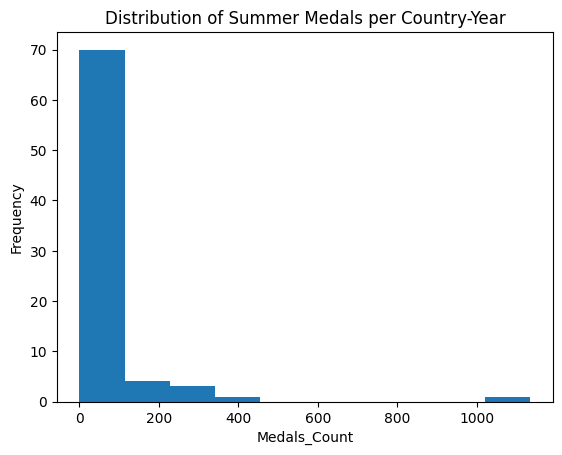

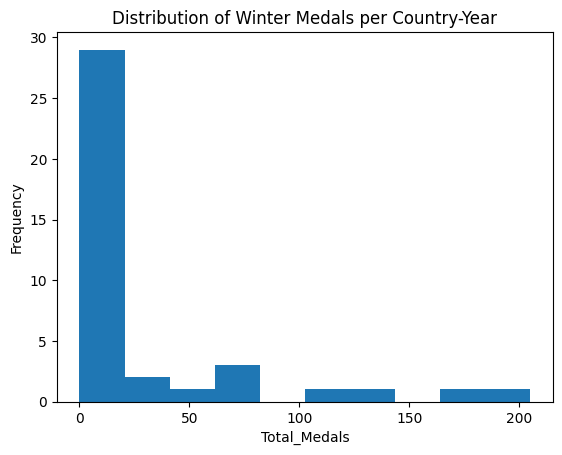

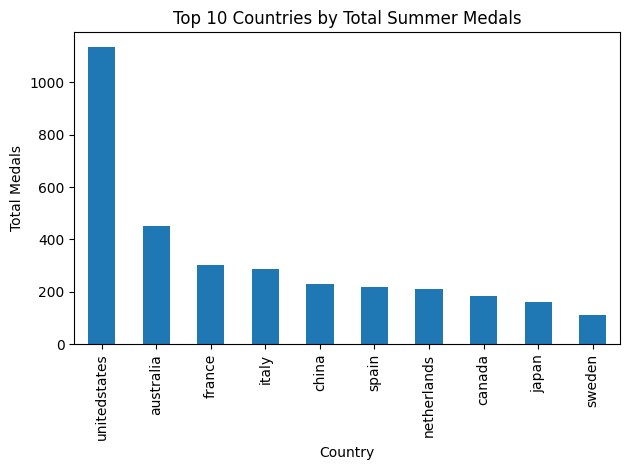

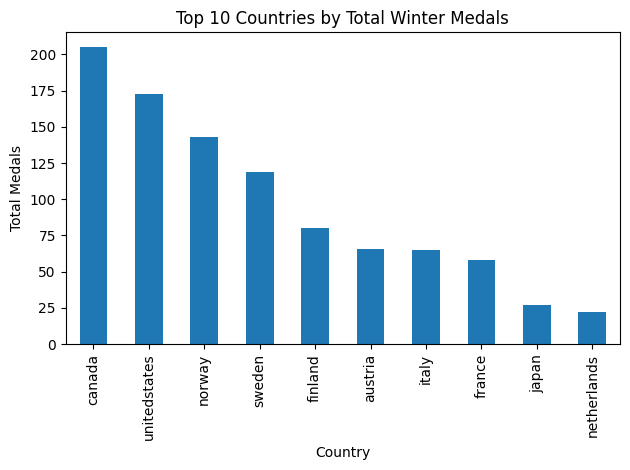

In [84]:
import matplotlib.pyplot as plt

# 1) Histogram of Summer
# Plot histogram of Summer.Winter Medals_Count
# Note: the y-axis “Frequency” shows the raw count of country–year records
#       that fall into each medal-count bin.
#       e.g. a bar of height 200 at 0 means 200 country–year entries had zero medals.
plt.figure()
plt.hist(summer_country['Total_Medals'].fillna(0))
plt.title('Distribution of Summer Medals per Country-Year')
plt.xlabel('Medals_Count')
plt.ylabel('Frequency')
plt.show()

# 2) Histogram of Winter Medals_Count
plt.figure()
plt.hist(winter_country['Total_Medals'].fillna(0))
plt.title('Distribution of Winter Medals per Country-Year')
plt.xlabel('Total_Medals')
plt.ylabel('Frequency')
plt.show()

# 3) Top 10 Countries by Total Summer Medals
summer_totals = summer_country.groupby('CountryName')['Total_Medals'].sum().sort_values(ascending=False).head(10)
plt.figure()
summer_totals.plot(kind='bar')
plt.title('Top 10 Countries by Total Summer Medals')
plt.xlabel('Country')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()

# 4) Top 10 Countries by Total Winter Medals
winter_totals = winter_country.groupby('CountryName')['Total_Medals'].sum().sort_values(ascending=False).head(10)
plt.figure()
winter_totals.plot(kind='bar')
plt.title('Top 10 Countries by Total Winter Medals')
plt.xlabel('Country')
plt.ylabel('Total Medals')
plt.tight_layout()
plt.show()


## Visualizing Medal Distribution and Top Countries

- **Purpose:**  
  This block provides a visual summary of how Olympic medals are distributed among countries and highlights the most successful countries in both Summer and Winter Games.

- **Step 1: Histogram of Summer Medals per Country-Year**  
  - Plots a histogram of `Total_Medals` for each country-year in the Summer Olympics.
  - The y-axis ("Frequency") indicates how many country-year records fall into each medal-count bin.
  - Example: A tall bar at 0 means many countries had years without winning any medals.

- **Step 2: Histogram of Winter Medals per Country-Year**  
  - Similar histogram for the Winter Olympics.
  - Visualizes the distribution of total medals won per country-year in the Winter Games.

- **Step 3: Top 10 Countries by Total Summer Medals**  
  - Aggregates and sums total medals for each country across all years in the Summer Olympics.
  - Displays a bar plot of the 10 countries with the highest overall medal counts.

- **Step 4: Top 10 Countries by Total Winter Medals**  
  - Repeats the same aggregation and bar plot for the Winter Olympics.
  - Highlights the dominant nations in Winter Olympic history.

- **Takeaway:**  
  These visualizations help reveal both the typical experience of most countries (often winning few or no medals) and identify the leading nations with the greatest Olympic success.


# Cleaning Country-Level Medal Data

- **Purpose:**  
  Ensures that only countries with at least one medal are retained for further analysis.

- **Step 1: Recompute Total Medals**  
  - For both Summer and Winter countries, recalculates `Total_Medals` as the sum of `Medals_Count` for each country using the grouped country-year data.
  - This step guarantees that the `Total_Medals` column is accurate and up-to-date.

- **Step 2: Drop Non-Medal-Winning Countries**  
  - Filters out countries with `Total_Medals` equal to 0, leaving only those countries that have won at least one medal.
  - Resets the index for a clean DataFrame.

- **Step 3: Print Remaining Rows**  
  - Prints the number of remaining country-year records for both Summer and Winter datasets, confirming the filter was applied.

- **Takeaway:**  
  By removing non-medal-winning countries, the analysis focuses on nations with actual Olympic success, providing clearer insight into the characteristics of winning countries.


In [86]:
# Recompute Total_Medals just in case
summer_country['Total_Medals'] = summer_df.groupby('CountryName')['Medals_Count'].transform('sum')
winter_country['Total_Medals'] = winter_df.groupby('CountryName')['Medals_Count'].transform('sum')

# Drop any country that never won a medal
summer_country = summer_country[summer_country['Total_Medals'] > 0].reset_index(drop=True)
winter_country = winter_country[winter_country['Total_Medals'] > 0].reset_index(drop=True)

print(f"Remaining Summer rows: {len(summer_df)}")
print(f"Remaining Winter rows: {len(winter_df)}")


Remaining Summer rows: 485
Remaining Winter rows: 133


In [87]:


# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Total_Medals'
numeric_feats = ['num_of_games', 'Population_mean', 'GDP_mean',"Host_any","Regime_any"]

X = summer_country[numeric_feats]
y = summer_country[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (63, 5)
X_test  shape: (16, 5)

PoissonReg R²: 0.146
Top coefficients (PoissonReg):
num_of_games       0.270618
Population_mean    0.261113
GDP_mean           0.090967
Host_any           0.000000
Regime_any         0.000000
dtype: float64

LinearReg R²: 0.122
Top coefficients (LinearReg):
num_of_games       29.450611
Population_mean    19.739948
GDP_mean            6.438933
Host_any            0.000000
Regime_any          0.000000
dtype: float64

RFRegressor R²: 0.170
Top permutation importances (RFRegressor):
num_of_games       0.246387
Population_mean    0.093795
GDP_mean           0.021514
Host_any           0.000000
Regime_any         0.000000
dtype: float64

XGBRegressor R²: 0.039
Top permutation importances (XGBRegressor):
num_of_games       0.156355
Population_mean    0.128177
GDP_mean           0.083298
Host_any           0.000000
Regime_any         0.000000
dtype: float64


## Final Country-Level Regression on Summer Olympics Medal Totals: Conclusion

- **Model Performance:**  
  - All models produced low R² values (PoissonRegressor: 0.146, LinearRegression: 0.122, RandomForestRegressor: 0.170, XGBRegressor: 0.039), indicating limited explanatory power for total medal counts among countries that have won at least one medal.
  - No model explained more than 17% of the variance, suggesting that at the country aggregation level, predicting total Olympic medal success is challenging with the current features.

- **Feature Importance:**  
  - **num_of_games** (number of Olympic Games attended) emerged as the most important predictor across all models.
  - **Population_mean** also contributed meaningfully, followed by **GDP_mean**, though both were less influential than participation frequency.
  - **Host_any** and **Regime_any** again showed no predictive value, highlighting that hosting the games or regime type are not key factors for overall medal success when compared to consistent participation and population size.

- **Takeaway:**  
  - At the country level, simply attending more Olympic Games and having a larger population are the main predictors of higher total medal counts, while economic strength is less important than in previous analyses.
  - The generally low R² scores emphasize that many other factors—such as sports infrastructure, athlete investment, tradition, and other socio-political variables—are likely important for explaining why some countries are more successful than others in the Olympics.
  - This analysis suggests that aggregate, country-level models have limited ability to capture the complexity of Olympic success with just demographic and economic features.


# winter_country

In [89]:


# ─── Block 4: Define features & target and train/test split ────────────────────
target = 'Total_Medals'
numeric_feats = ['num_of_games', 'Population_mean', 'GDP_mean',"Host_any","Regime_any"]

X = winter_country[numeric_feats]
y = winter_country[target].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# ─── Block 5: Preprocessing pipeline ──────────────────────────────────────────
# We'll standardize all numeric features.
pre = StandardScaler()

# ─── Block 6: Define regression models ────────────────────────────────────────
models = {
    'PoissonReg':   Pipeline([('pre', pre), ('clf', PoissonRegressor())]),
    'LinearReg':    Pipeline([('pre', pre), ('clf', LinearRegression())]),
    'RFRegressor':  Pipeline([('pre', pre), ('clf', RandomForestRegressor(random_state=42))]),
    'XGBRegressor': Pipeline([('pre', pre), ('clf', XGBRegressor(random_state=42))]),
}

# ─── Block 7: Fit, evaluate & extract importances ─────────────────────────────
for name, pipe in models.items():
    # Fit
    pipe.fit(X_train, y_train)
    # R² on test set
    r2 = pipe.score(X_test, y_test)
    print(f'\n{name} R²: {r2:.3f}')

    # Feature importances / coefficients
    if name in ('PoissonReg', 'LinearReg'):
        coefs = pipe.named_steps['clf'].coef_
        imp = pd.Series(coefs, index=numeric_feats).abs().sort_values(ascending=False)
        print(f'Top coefficients ({name}):')
        print(imp)
    else:
        r = permutation_importance(
            pipe, X_test, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        imp = pd.Series(r.importances_mean, index=numeric_feats).sort_values(ascending=False)
        print(f'Top permutation importances ({name}):')
        print(imp)


X_train shape: (31, 5)
X_test  shape: (8, 5)

PoissonReg R²: -0.167
Top coefficients (PoissonReg):
num_of_games       0.335477
Population_mean    0.025917
GDP_mean           0.006800
Host_any           0.000000
Regime_any         0.000000
dtype: float64

LinearReg R²: -0.180
Top coefficients (LinearReg):
num_of_games       26.498423
Population_mean     2.411227
GDP_mean            1.717049
Host_any            0.000000
Regime_any          0.000000
dtype: float64

RFRegressor R²: 0.104
Top permutation importances (RFRegressor):
Population_mean    0.264793
num_of_games       0.240079
GDP_mean           0.065273
Host_any           0.000000
Regime_any         0.000000
dtype: float64

XGBRegressor R²: -1.206
Top permutation importances (XGBRegressor):
Regime_any         0.000000
Host_any           0.000000
num_of_games      -0.150341
GDP_mean          -0.210264
Population_mean   -0.294122
dtype: float64


## Final Country-Level Regression on Winter Olympics Medal Totals: Conclusion

- **Model Performance:**  
  - The regression models performed poorly, with most showing negative R² values (PoissonRegressor: -0.167, LinearRegression: -0.180, XGBRegressor: -1.206). Only the RandomForestRegressor achieved a slightly positive R² (0.104), indicating it explained about 10% of the variance.
  - Negative R² means these models predict medal totals worse than simply using the mean medal count for all countries, highlighting the difficulty of modeling Winter Olympic success at the country level with the given features.

- **Feature Importance:**  
  - **num_of_games** (number of Winter Olympic Games attended) and **Population_mean** appeared as the most relevant features, especially in Poisson, Linear, and Random Forest models.
  - **GDP_mean** had some importance but was always much less influential than participation and population.
  - **Host_any** and **Regime_any** contributed nothing across all models.
  - In XGBoost, all features had either zero or negative importance, reflecting the model's inability to capture a useful relationship in this dataset.

- **Takeaway:**  
  - Predicting total Winter Olympic medal success at the country level using just demographic, economic, and participation features is not effective; the low and negative R² values suggest that critical factors are missing.
  - Regular participation and population size matter somewhat, but alone they are insufficient to explain which countries win more medals in the Winter Olympics.
  - This result highlights the unique, unpredictable, or highly specialized nature of Winter Olympic sports, and the need for additional country-level features (e.g., investment in winter sports, climate, tradition, or athlete-level data) to build a more predictive model.
